# Fusion de Données et Analyse Exploratoire (EDA) pour Modèle ML

## Prédiction de l'Achalandage Cycliste à Montréal

Ce notebook fournit un flux de travail complet pour:
1. **Intégrer** quatre jeux de données hétérogènes
2. **Nettoyer et valider** les données
3. **Fusionner** selon des clés temporelles et spatiales
4. **Analyser** les patterns cyclistes
5. **Préparer** les données pour un modèle supervisé

### Ce modèle peut aider à répondre à des questions comme :

- Quels types de pistes attirent le plus de cyclistes dans des zones à fort trafic ?
- Les travaux routiers réduisent-ils l’achalandage cycliste ?
- Est-ce que les pistes dans des zones calmes sont plus utilisées ?
- Il est aussi possible d'ajouter la meteo pour prédire l'acalendage selon la météo (API)
### Jeux de Données

| Jeu | Description | Période |
|-----|-------------|---------|
| **Comptage vélos** | Passages horaires par station | 2025 (15 min) |
| **Météo** | Température, précipitations, vent, humidité | 2022-2025 (horaire) |
| **Travaux (Entraves)** | Projets de construction/maintenance | 2025-2028 |
| **Réseau cyclable** | Géométrie et types de pistes | Statique |

### Objectif Pédagogique

Préparer un **dataset fusionné** de haute qualité pour un modèle de régression/classification qui prédit:
- **Variable cible**: Nombre de passages de vélos (`nb_passages`)
- **Variables explicatives**: Conditions météo, heures, travaux proximaux, type d'infrastructure

## Liens de téléchargement des données

- [Comptage des vélos sur les pistes cyclables](https://donnees.montreal.ca/dataset/velos-comptage)
- [Travaux routiers en cours (Info-travaux)](https://donnees.montreal.ca/en/dataset/info-travaux)
- [Réseau cyclable](https://donnees.montreal.ca/fr/dataset/pistes-cyclables)
- [API météo](https://archive-api.open-meteo.com/v1/archive)

In [62]:
# Importation des librairies nécessaires
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy.spatial.distance import euclidean
import warnings
warnings.filterwarnings('ignore')

# Configuration pour l'affichage
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" Librairies importées avec succès")
print(" Configuration affichage optimisée")

 Librairies importées avec succès
 Configuration affichage optimisée




#  1. Chargement et Exploration des Jeux de Données

**Objectif**: Comprendre la structure, les dimensions et la qualité de chaque source de données avant fusion.

## 1.1 Charger les Données de Comptage Cycliste

Les stations de comptage enregistrent les passages de cyclistes à intervalle régulier (15 minutes) avec localisation GPS.

In [63]:
# Charger le fichier CSV des comptages vélos 2025
df_velo = pd.read_csv('comptage_velo_2025.csv', sep=';')

print("=" * 80)
print("DONNÉES DE COMPTAGE CYCLISTE - APERÇU GÉNÉRAL")
print("=" * 80)
print(f"\nDimensions du dataset: {df_velo.shape[0]:,} lignes × {df_velo.shape[1]} colonnes")
print(f"\nColonnes disponibles:")
for i, col in enumerate(df_velo.columns, 1):
    print(f"   {i}. {col}")

print(f"\nTypes de données:")
print(df_velo.dtypes)

print(f"\nValeurs manquantes (en %):")
missing_pct = (df_velo.isnull().sum() / len(df_velo)) * 100
for col, pct in missing_pct[missing_pct > 0].items():
    print(f"   {col}: {pct:.2f}%")
if missing_pct.sum() == 0:
    print("    Aucune valeur manquante")

print(f"\nStatistiques descriptives (nb_passages):")
print(df_velo['nb_passages'].describe())

print(f"\nValidation des coordonnées géographiques:")
print(f"   Longitude: {df_velo['longitude'].min():.2f}° à {df_velo['longitude'].max():.2f}°")
print(f"   Latitude:  {df_velo['latitude'].min():.2f}° à {df_velo['latitude'].max():.2f}°")
print(f"    Valeurs attendues pour Montréal: -74.5 à -73 / 45 à 46")

print(f"\nPremiers enregistrements:")
display(df_velo.head(3))

DONNÉES DE COMPTAGE CYCLISTE - APERÇU GÉNÉRAL

Dimensions du dataset: 775,481 lignes × 6 colonnes

Colonnes disponibles:
   1. date
   2. heure
   3. id_compteur
   4. nb_passages
   5. longitude
   6. latitude

Types de données:
date            object
heure           object
id_compteur      int64
nb_passages    float64
longitude      float64
latitude       float64
dtype: object

Valeurs manquantes (en %):
   nb_passages: 0.00%

Statistiques descriptives (nb_passages):
count    775477.000000
mean         10.429026
std          20.813004
min           0.000000
25%           0.000000
50%           2.000000
75%          11.000000
max         434.000000
Name: nb_passages, dtype: float64

Validation des coordonnées géographiques:
   Longitude: -73.67° à -73.48°
   Latitude:  45.47° à 45.70°
    Valeurs attendues pour Montréal: -74.5 à -73 / 45 à 46

Premiers enregistrements:


,date,heure,id_compteur,nb_passages,longitude,latitude
0,2025-01-01,00:00:00,100054073,0.0,-73.590636,45.560713
1,2025-01-01,00:00:00,300021685,0.0,-73.613370,45.631590
2,2025-01-01,00:00:00,100003040,0.0,-73.544410,45.501270


## 1.2 Charger les Données Météorologiques

Observations horaires de Montréal: température, précipitations, vent, humidité, couverture nuageuse.

In [64]:
# Charger le fichier météo horaire extraire de l'API météo pour Montréal (2022-2025)
df_meteo = pd.read_csv('meteo_montreal_horaire.csv', sep=';')

print("=" * 80)
print("DONNÉES MÉTÉOROLOGIQUES - APERÇU GÉNÉRAL")
print("=" * 80)
print(f"\n Dimensions: {df_meteo.shape[0]:,} lignes × {df_meteo.shape[1]} colonnes")
print(f"   (Couvre {df_meteo['date'].nunique()} jours distincts)")

print(f"\n Colonnes disponibles:")
for i, col in enumerate(df_meteo.columns, 1):
    print(f"   {i}. {col}")

print(f"\n Types de données:")
print(df_meteo.dtypes)

print(f"\n Couverture temporelle:")
print(f"   Du: {df_meteo['date'].min()}")
print(f"   Au: {df_meteo['date'].max()}")

print(f"\n  Valeurs manquantes:")
missing_cols = df_meteo.isnull().sum()
if missing_cols.sum() == 0:
    print("    Aucune valeur manquante")
else:
    print(missing_cols[missing_cols > 0])

print(f"\n  Plages de variables météo:")
print(f"   Température:   {df_meteo['temp_c'].min():.1f}°C à {df_meteo['temp_c'].max():.1f}°C")
print(f"   Précipitations: {df_meteo['precip_mm'].min():.1f}mm à {df_meteo['precip_mm'].max():.1f}mm")
print(f"   Vent:          {df_meteo['wind_kmh'].min():.1f}km/h à {df_meteo['wind_kmh'].max():.1f}km/h")
print(f"   Humidité:      {df_meteo['humidite_pct'].min():.0f}% à {df_meteo['humidite_pct'].max():.0f}%")
print(f"   Nuages:        {df_meteo['cloud_pct'].min():.0f}% à {df_meteo['cloud_pct'].max():.0f}%")

print(f"\n  Premiers enregistrements:")
display(df_meteo.head(3))

DONNÉES MÉTÉOROLOGIQUES - APERÇU GÉNÉRAL

 Dimensions: 32,136 lignes × 7 colonnes
   (Couvre 1339 jours distincts)

 Colonnes disponibles:
   1. date
   2. heure
   3. temp_c
   4. precip_mm
   5. wind_kmh
   6. humidite_pct
   7. cloud_pct

 Types de données:
date             object
heure            object
temp_c          float64
precip_mm       float64
wind_kmh        float64
humidite_pct      int64
cloud_pct         int64
dtype: object

 Couverture temporelle:
   Du: 2022-01-01
   Au: 2025-08-31

  Valeurs manquantes:
    Aucune valeur manquante

  Plages de variables météo:
   Température:   -31.6°C à 34.2°C
   Précipitations: 0.0mm à 35.1mm
   Vent:          0.0km/h à 43.5km/h
   Humidité:      18% à 100%
   Nuages:        0% à 100%

  Premiers enregistrements:


,date,heure,temp_c,precip_mm,wind_kmh,humidite_pct,cloud_pct
0,2022-01-01,00:00:00,-2.8,0.0,2.1,99,100
1,2022-01-01,01:00:00,-3.7,0.0,2.3,99,100
2,2022-01-01,02:00:00,-2.9,0.0,4.5,98,100


## 1.3 Charger les Données des Entraves (Travaux)

Projets de construction et maintenance: localisation, durée, type d'obstruction affectant le réseau cyclable.

In [65]:
# Charger les données des entraves/travaux en cours
df_entraves = pd.read_csv('entraves-travaux-en-cours.csv', sep=',')

print("=" * 80)
print("DONNÉES DES ENTRAVES/TRAVAUX - APERÇU GÉNÉRAL")
print("=" * 80)
print(f"\n Dimensions du dataset: {df_entraves.shape[0]:,} lignes × {df_entraves.shape[1]} colonnes")
print(f" Colonnes: {list(df_entraves.columns)}")
print(f"\n Types de données:")
print(df_entraves.dtypes)

print(f"\n Valeurs manquantes (%):")
missing_pct = (df_entraves.isnull().sum() / len(df_entraves) * 100).round(2)
for col, pct in missing_pct[missing_pct > 0].items():
    print(f"   • {col}: {pct}%")
if missing_pct.sum() == 0:
    print("    Aucune valeur manquante détectée")

print(f"\n Couverture géographique:")
if 'longitude' in df_entraves.columns and 'latitude' in df_entraves.columns:
    lon_valid = ((df_entraves['longitude'] >= -74.5) & (df_entraves['longitude'] <= -73)).sum()
    lat_valid = ((df_entraves['latitude'] >= 45) & (df_entraves['latitude'] <= 46)).sum()
    print(f"   • Longitude valide (Montréal): {lon_valid}/{len(df_entraves)} ({lon_valid/len(df_entraves)*100:.1f}%)")
    print(f"   • Latitude valide (Montréal): {lat_valid}/{len(df_entraves)} ({lat_valid/len(df_entraves)*100:.1f}%)")
    print(f"   • Lon: [{df_entraves['longitude'].min():.4f}, {df_entraves['longitude'].max():.4f}]")
    print(f"   • Lat: [{df_entraves['latitude'].min():.4f}, {df_entraves['latitude'].max():.4f}]")

print(f"\n Couverture temporelle (avant expansion):")
if 'duration_start_date' in df_entraves.columns:
    print(f"   • Première date: {df_entraves['duration_start_date'].min()}")
    print(f"   • Dernière date: {df_entraves['duration_end_date'].max()}")
    
print(f"\n Catégories de travaux:")
if 'reason_category' in df_entraves.columns:
    category_counts = df_entraves['reason_category'].value_counts()
    for cat, count in category_counts.items():
        pct = count / len(df_entraves) * 100
        print(f"   • {cat}: {count} ({pct:.1f}%)")

print(f"\n Aperçu des 3 premières lignes:")
display(df_entraves.head(3))

DONNÉES DES ENTRAVES/TRAVAUX - APERÇU GÉNÉRAL

 Dimensions du dataset: 2,363 lignes × 43 colonnes
 Colonnes: ['id', 'permit_permit_id', 'contractnumber', 'boroughid', 'permitcategory', 'currentstatus', 'duration_start_date', 'duration_end_date', 'reason_category', 'occupancy_name', 'submittercategory', 'organizationname', 'duration_days_mon_active', 'duration_days_mon_all_day_round', 'duration_days_tue_active', 'duration_days_tue_all_day_round', 'duration_days_wed_active', 'duration_days_wed_all_day_round', 'duration_days_thu_active', 'duration_days_thu_all_day_round', 'duration_days_fri_active', 'duration_days_fri_all_day_round', 'duration_days_sat_active', 'duration_days_sat_all_day_round', 'duration_days_sun_active', 'duration_days_sun_all_day_round', 'duration_days_sat_start_time', 'duration_days_sat_end_time', 'duration_days_mon_start_time', 'duration_days_mon_end_time', 'duration_days_tue_start_time', 'duration_days_tue_end_time', 'duration_days_wed_start_time', 'duration_days_we

,id,permit_permit_id,contractnumber,boroughid,permitcategory,currentstatus,duration_start_date,duration_end_date,reason_category,occupancy_name,submittercategory,organizationname,duration_days_mon_active,duration_days_mon_all_day_round,duration_days_tue_active,duration_days_tue_all_day_round,duration_days_wed_active,duration_days_wed_all_day_round,duration_days_thu_active,duration_days_thu_all_day_round,duration_days_fri_active,duration_days_fri_all_day_round,duration_days_sat_active,duration_days_sat_all_day_round,duration_days_sun_active,duration_days_sun_all_day_round,duration_days_sat_start_time,duration_days_sat_end_time,duration_days_mon_start_time,duration_days_mon_end_time,duration_days_tue_start_time,duration_days_tue_end_time,duration_days_wed_start_time,duration_days_wed_end_time,duration_days_thu_start_time,duration_days_thu_end_time,duration_days_fri_start_time,duration_days_fri_end_time,duration_days_sun_start_time,duration_days_sun_end_time,load_date,longitude,latitude
0,67cf03dac73b0c001ec47665,OCC-2503BS09342738,NaN,Ahuntsic-Cartierville,Travaux,Permis émis,2025-03-16T20:00:00Z,2025-10-17T19:59:59Z,Construction/rénovation sans excavation,Parthenais entre Sauriol et Parthenais,Entreprise,Groupe Geyser inc.,t,t,t,t,t,t,t,t,t,t,t,t,t,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-13T00:01:30Z,-73.649104,45.571998
1,684c1aa6608c140012af3ac5,OCC-2506LE10962180,1715250,Mercier-Hochelaga-Maisonneuve,Travaux,Permis émis,2025-06-18T20:00:00Z,2025-10-01T19:59:59Z,Égouts et aqueducs - Inspection et nettoyage,Robert-Jurie entre Desautels et Arcand,Entrepreneur sous contrat avec la Ville de Mon...,NORDIKEAU INC,t,f,t,f,t,f,t,f,t,f,f,f,f,f,NaN,NaN,07:00,17:00,07:00,17:00,07:00,17:00,07:00,17:00,07:00,17:00,NaN,NaN,2025-06-15T00:01:21Z,-73.540975,45.584426
2,68ae04d52d0a57001270bfed,OCC-2508HU24027957,NaN,St-Laurent,Travaux,Permis émis,2025-09-01T20:00:00Z,2025-10-10T19:59:59Z,Autre,Bonin entre Gratton et Côte-Vertu,RTU (Réseau technique urbain) ou son sous-trai...,Lanauco,t,f,t,f,t,f,t,f,t,f,f,f,f,f,NaN,NaN,07:00,16:00,07:00,16:00,07:00,16:00,07:00,16:00,07:00,16:00,NaN,NaN,2025-08-30T00:01:54Z,-73.690751,45.506435


## 1.4 Charger les Données du Réseau Cyclable

Infrastructure des voies cyclables en format GeoJSON: localisation des segments, type de voie, caractéristiques géométriques.

In [66]:
# Charger les données du réseau cyclable (GeoJSON)
import json

with open('reseau_cyclable.json', 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Extraire les coordonnées et propriétés des segments
features = geojson_data.get('features', [])
print("=" * 80)
print("DONNÉES DU RÉSEAU CYCLABLE - APERÇU GÉNÉRAL (GeoJSON)")
print("=" * 80)
print(f"\n Nombre de segments (features): {len(features)}")

# Créer un DataFrame à partir des propriétés GeoJSON
segments_list = []
for feature in features:
    props = feature.get('properties', {})
    geom = feature.get('geometry', {})
    
    # Extraire les coordonnées (pour les LineString)
    if geom.get('type') == 'LineString':
        coords = geom.get('coordinates', [])
        # Prendre le centroïde approximatif (coordonnée du milieu)
        mid_idx = len(coords) // 2
        if len(coords) > 0:
            lon, lat = coords[mid_idx]
        else:
            lon, lat = None, None
    else:
        lon, lat = None, None
    
    segment_data = {
        'geometry_type': geom.get('type'),
        'longueur': props.get('LONGUEUR'),
        'type_voie': props.get('TYPE_VOIE_DESC'),
        'nom_arr': props.get('NOM_ARR_VILLE'),
        'num_secteur': props.get('NUM_SECTEUR'),
        'latitude': lat,
        'longitude': lon
    }
    segments_list.append(segment_data)

df_reseau = pd.DataFrame(segments_list)

print(f"\n Dimensions du dataset réseau: {df_reseau.shape[0]:,} segments × {df_reseau.shape[1]} colonnes")
print(f" Colonnes: {list(df_reseau.columns)}")

print(f"\n Types de géométrie:")
print(df_reseau['geometry_type'].value_counts())

print(f"\n  Valeurs manquantes (%):")
missing_pct = (df_reseau.isnull().sum() / len(df_reseau) * 100).round(2)
for col, pct in missing_pct[missing_pct > 0].items():
    print(f"   • {col}: {pct}%")

print(f"\n  Types de voies disponibles:")
if df_reseau['type_voie'].notna().any():
    voie_counts = df_reseau['type_voie'].value_counts()
    for voie, count in voie_counts.head(10).items():
        pct = count / len(df_reseau) * 100
        print(f"   • {voie}: {count} ({pct:.1f}%)")

print(f"\n  Couverture géographique du réseau:")
if df_reseau['longitude'].notna().any() and df_reseau['latitude'].notna().any():
    valid_coords = df_reseau.dropna(subset=['longitude', 'latitude'])
    print(f"   • Segments avec coordonnées: {len(valid_coords)}/{len(df_reseau)}")
    print(f"   • Lon: [{valid_coords['longitude'].min():.4f}, {valid_coords['longitude'].max():.4f}]")
    print(f"   • Lat: [{valid_coords['latitude'].min():.4f}, {valid_coords['latitude'].max():.4f}]")

print(f"\n  Statistiques sur la longueur des segments:")
if df_reseau['longueur'].notna().any():
    print(f"   • Moyenne: {df_reseau['longueur'].mean():.2f} m")
    print(f"   • Médiane: {df_reseau['longueur'].median():.2f} m")
    print(f"   • Min: {df_reseau['longueur'].min():.2f} m")
    print(f"   • Max: {df_reseau['longueur'].max():.2f} m")
    print(f"   • Longueur totale du réseau: {df_reseau['longueur'].sum()/1000:.2f} km")

print(f"\n  Aperçu de 3 segments:")
display(df_reseau[['type_voie', 'longueur', 'nom_arr', 'latitude', 'longitude']].head(3))

DONNÉES DU RÉSEAU CYCLABLE - APERÇU GÉNÉRAL (GeoJSON)

 Nombre de segments (features): 9314

 Dimensions du dataset réseau: 9,314 segments × 7 colonnes
 Colonnes: ['geometry_type', 'longueur', 'type_voie', 'nom_arr', 'num_secteur', 'latitude', 'longitude']

 Types de géométrie:
geometry_type
LineString    9314
Name: count, dtype: int64

  Valeurs manquantes (%):
   • nom_arr: 100.0%
   • num_secteur: 100.0%

  Types de voies disponibles:
   • Bande cyclable: 2454 (26.3%)
   • Chaussée désignée: 2363 (25.4%)
   • Piste cyclable sur rue: 1862 (20.0%)
   • Piste cyclable en site propre: 1771 (19.0%)
   • Sentier polyvalent: 547 (5.9%)
   • Piste cyclable au niveau du trottoir: 156 (1.7%)
   • Voie partagée Bus-Vélo: 94 (1.0%)
   • Vélorue: 63 (0.7%)
   • Inconnu: 4 (0.0%)

  Couverture géographique du réseau:
   • Segments avec coordonnées: 9314/9314
   • Lon: [-73.9693, -73.4801]
   • Lat: [45.4027, 45.7019]

  Statistiques sur la longueur des segments:
   • Moyenne: 116.19 m
   • Médian

,type_voie,longueur,nom_arr,latitude,longitude
0,Sentier polyvalent,1074,None,45.499871,-73.589621
1,Sentier polyvalent,644,None,45.558823,-73.619484
2,Sentier polyvalent,12,None,45.672178,-73.517657




# 2. Nettoyage et Prétraitement des Données

Standardisation des formats, gestion des valeurs manquantes, validation des plages de données, création de clés de fusion.

## 2.1 Nettoyer les Données de Comptage Cycliste

Standardiser les colonnes de date/heure, supprimer les doublons, valider les plages numériques.

In [67]:
# Nettoyer les données de comptage cycliste
print("NETTOYAGE - COMPTAGE CYCLISTE")
df_velo_clean = df_velo.copy()

# Créer datetime
df_velo_clean['datetime'] = pd.to_datetime(
    df_velo_clean['date'] + ' ' + df_velo_clean['heure'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)
df_velo_clean['date_normalized'] = df_velo_clean['datetime'].dt.date
df_velo_clean['heure_normalized'] = df_velo_clean['datetime'].dt.strftime('%H:%M:%S')

# Supprimer doublons
duplicates_before = df_velo_clean.duplicated(subset=['date', 'heure', 'id_compteur']).sum()
df_velo_clean = df_velo_clean.drop_duplicates(subset=['date', 'heure', 'id_compteur'], keep='first')

# Valider nb_passages
if (df_velo_clean['nb_passages'] < 0).sum() > 0:
    df_velo_clean = df_velo_clean[df_velo_clean['nb_passages'] >= 0]

# Valider coordonnées
coords_before = len(df_velo_clean)
df_velo_clean = df_velo_clean[
    (df_velo_clean['longitude'] >= -74.5) & (df_velo_clean['longitude'] <= -73) &
    (df_velo_clean['latitude'] >= 45) & (df_velo_clean['latitude'] <= 46)
]
coords_removed = coords_before - len(df_velo_clean)

# Résumé
print(f"Avant: {df_velo.shape[0]:,} lignes")
print(f"Après: {df_velo_clean.shape[0]:,} lignes")
print(f"Doublons: {duplicates_before}, Coords invalides: {coords_removed}")
print("Prêt pour fusion")

NETTOYAGE - COMPTAGE CYCLISTE
Avant: 775,481 lignes
Après: 775,477 lignes
Doublons: 4, Coords invalides: 0
Prêt pour fusion
Avant: 775,481 lignes
Après: 775,477 lignes
Doublons: 4, Coords invalides: 0
Prêt pour fusion


## 2.2 Nettoyer les Données Météorologiques

Standardiser les formats, interpoler les valeurs manquantes, valider les plages scientifiques.

In [68]:
# Nettoyer les données météorologiques
print("NETTOYAGE - DONNÉES MÉTÉOROLOGIQUES")
df_meteo_clean = df_meteo.copy()

# Créer datetime
df_meteo_clean['datetime'] = pd.to_datetime(
    df_meteo_clean['date'] + ' ' + df_meteo_clean['heure'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'
)

# Gestion des valeurs manquantes
missing_cols = df_meteo_clean.columns[df_meteo_clean.isnull().any()].tolist()
numeric_cols = df_meteo_clean[missing_cols].select_dtypes(include=[np.number]).columns if missing_cols else []
for col in numeric_cols:
    df_meteo_clean[col] = df_meteo_clean[col].interpolate(method='linear', limit_direction='both')

# Valider plages
validations = {
    'temp_c': (-40, 50),
    'precip_mm': (0, 500),
    'wind_kmh': (0, 200),
    'humidite_pct': (0, 100)
}

for col, (min_val, max_val) in validations.items():
    if col in df_meteo_clean.columns:
        out_of_range = ((df_meteo_clean[col] < min_val) | (df_meteo_clean[col] > max_val)).sum()
        if out_of_range > 0:
            df_meteo_clean.loc[(df_meteo_clean[col] < min_val) | (df_meteo_clean[col] > max_val), col] = np.nan
            df_meteo_clean[col] = df_meteo_clean[col].interpolate(method='linear', limit_direction='both')

print(f"Avant: {df_meteo.shape[0]:,} lignes")
print(f"Après: {df_meteo_clean.shape[0]:,} lignes")
print(f"Période: {df_meteo_clean['datetime'].min()} à {df_meteo_clean['datetime'].max()}")
print("Prêt pour fusion")

NETTOYAGE - DONNÉES MÉTÉOROLOGIQUES
Avant: 32,136 lignes
Après: 32,136 lignes
Période: 2022-01-01 00:00:00 à 2025-08-31 23:00:00
Prêt pour fusion


## 2.3 Nettoyer et Développer les Données des Entraves

Valider les plages de dates, expander les entraves sur chaque jour de la durée, normaliser les coordonnées.

In [69]:
# Nettoyer et développer les données des entraves
print("NETTOYAGE - DONNÉES D'ENTRAVES")
df_entraves_clean = df_entraves.copy()

# Convertir les dates
df_entraves_clean['date_debut'] = pd.to_datetime(
    df_entraves_clean['duration_start_date'],
    errors='coerce'
).dt.date

df_entraves_clean['date_fin'] = pd.to_datetime(
    df_entraves_clean['duration_end_date'],
    errors='coerce'
).dt.date

# Développer les entraves par jour
entraves_expanded = []
for idx, row in df_entraves_clean.iterrows():
    date_debut = row['date_debut']
    date_fin = row['date_fin']
    
    if pd.notna(date_debut) and pd.notna(date_fin):
        date_range = pd.date_range(start=date_debut, end=date_fin, freq='D')
        for date in date_range:
            new_row = row.copy()
            new_row['date_entrave'] = date.date()
            entraves_expanded.append(new_row)

df_entraves_expanded = pd.DataFrame(entraves_expanded)

# Valider coordonnées
if 'longitude' in df_entraves_expanded.columns and 'latitude' in df_entraves_expanded.columns:
    coords_before = len(df_entraves_expanded)
    df_entraves_expanded = df_entraves_expanded.dropna(subset=['longitude', 'latitude']).reset_index(drop=True)
    df_entraves_expanded = df_entraves_expanded[
        (df_entraves_expanded['longitude'] >= -74.5) & (df_entraves_expanded['longitude'] <= -73) &
        (df_entraves_expanded['latitude'] >= 45) & (df_entraves_expanded['latitude'] <= 46)
    ].reset_index(drop=True)
    coords_removed = coords_before - len(df_entraves_expanded)
else:
    coords_removed = 0

# Résumé
print(f"Avant: {len(df_entraves_clean)} projets")
print(f"Après expansion: {len(df_entraves_expanded):,} enregistrements")
if len(df_entraves_clean) > 0:
    print(f"Facteur d'expansion: {len(df_entraves_expanded) / len(df_entraves_clean):.1f}x")
print("Prêt pour fusion")

NETTOYAGE - DONNÉES D'ENTRAVES
Avant: 2363 projets
Après expansion: 223,595 enregistrements
Facteur d'expansion: 94.6x
Prêt pour fusion
Avant: 2363 projets
Après expansion: 223,595 enregistrements
Facteur d'expansion: 94.6x
Prêt pour fusion



#  3. Fusion des Datasets

Combiner les 4 sources de données par clés temporelles et spatiales pour créer un dataset unifié.

## 3.1 Fusion Temporelle: Comptages + Météo

Joindre les comptages cyclistes avec les données météorologiques horaires (LEFT JOIN).

In [70]:
# Fusion temporelle: comptages + météo
print("FUSION TEMPORELLE - COMPTAGES + MÉTÉO")

# Préparer les clés de fusion
df_velo_clean['date_str'] = df_velo_clean['date_normalized'].astype(str)
df_velo_clean['heure_str'] = df_velo_clean['heure_normalized'].astype(str)

df_meteo_clean['date_str'] = df_meteo_clean['date'].astype(str)
df_meteo_clean['heure_str'] = df_meteo_clean['heure'].astype(str)

# Fusionner
df_merged_meteo = df_velo_clean.merge(
    df_meteo_clean[['date_str', 'heure_str', 'temp_c', 'precip_mm', 
                    'wind_kmh', 'humidite_pct', 'cloud_pct']],
    on=['date_str', 'heure_str'],
    how='left'
)

# Analyser les correspondances
matched = df_merged_meteo['temp_c'].notna().sum()
match_pct = matched / len(df_merged_meteo) * 100

FUSION TEMPORELLE - COMPTAGES + MÉTÉO


In [71]:
print(f"Comptages avant: {len(df_velo_clean):,}")
print(f"Après fusion: {len(df_merged_meteo):,} lignes")
print(f"Avec données météo: {matched:,} ({match_pct:.1f}%)")
print("Prêt pour nettoyage: vérifier valeurs manquantes")

Comptages avant: 775,477
Après fusion: 775,477 lignes
Avec données météo: 193,871 (25.0%)
Prêt pour nettoyage: vérifier valeurs manquantes


In [72]:
# Corriger les données manquantes APRÈS fusion météo
print("=" * 80)
print("CORRECTION DES DONNÉES MANQUANTES - INTERPOLATION LINÉAIRE")
print("=" * 80)

df_merged_meteo_clean = df_merged_meteo.copy()
meteo_cols = ['temp_c', 'precip_mm', 'wind_kmh', 'humidite_pct', 'cloud_pct']

# État AVANT
missing_before_total = df_merged_meteo_clean[meteo_cols].isnull().sum().sum()
print(f"\nAVANT: {missing_before_total:,} valeurs manquantes ({missing_before_total/(len(df_merged_meteo_clean)*len(meteo_cols))*100:.1f}%)")

# Trier par datetime et interpoler
df_merged_meteo_clean = df_merged_meteo_clean.sort_values('datetime').reset_index(drop=True)

print("Interpolation linéaire en cours...")
for col in meteo_cols:
    missing_count = df_merged_meteo_clean[col].isnull().sum()
    if missing_count > 0:
        df_merged_meteo_clean[col] = df_merged_meteo_clean[col].interpolate(method='linear', limit_direction='both')
        if df_merged_meteo_clean[col].isnull().any():
            df_merged_meteo_clean[col].fillna(df_merged_meteo_clean[col].median(), inplace=True)

# État APRÈS
missing_after_total = df_merged_meteo_clean[meteo_cols].isnull().sum().sum()
print(f"\nAPRÈS: {missing_after_total:,} valeurs manquantes")
print(f"\nRésultat final:")
print(f"   Lignes: {len(df_merged_meteo_clean):,}")
print(f"   Colonnes météo complètes: {len(meteo_cols)}/5")
print(f"   Complétude: {(1 - missing_after_total/(len(df_merged_meteo_clean)*len(meteo_cols)))*100:.1f}%")
print("Données prêtes pour les fusions spatiales")

CORRECTION DES DONNÉES MANQUANTES - INTERPOLATION LINÉAIRE

AVANT: 2,908,030 valeurs manquantes (75.0%)

AVANT: 2,908,030 valeurs manquantes (75.0%)
Interpolation linéaire en cours...
Interpolation linéaire en cours...

APRÈS: 0 valeurs manquantes

Résultat final:
   Lignes: 775,477
   Colonnes météo complètes: 5/5
   Complétude: 100.0%
Données prêtes pour les fusions spatiales

APRÈS: 0 valeurs manquantes

Résultat final:
   Lignes: 775,477
   Colonnes météo complètes: 5/5
   Complétude: 100.0%
Données prêtes pour les fusions spatiales


## 3.2 Fusion Spatiale: Comptages + Réseau Cyclable

Identifier le segment de réseau le plus proche de chaque compteur (recherche du voisin le plus proche).

In [73]:
# Fusion spatiale: comptages + réseau cyclable (recherche du voisin le plus proche)
from scipy.spatial import cKDTree

print("=" * 80)
print("FUSION SPATIALE: COMPTAGES + RÉSEAU CYCLABLE")
print("=" * 80)

# Fonction pour calculer la distance Haversine (km)
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance Haversine en km entre deux points"""
    from math import radians, cos, sin, asin, sqrt
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Rayon de la Terre en km
    return c * r

# Préparation des données spatiales
coords_compteurs = df_merged_meteo[['id_compteur', 'longitude', 'latitude']].drop_duplicates()
coords_reseau = df_reseau.dropna(subset=['longitude', 'latitude'])

print("FUSION SPATIALE - COMPTAGES + RÉSEAU CYCLABLE")
print(f"Compteurs uniques: {len(coords_compteurs)}")
print(f"Segments de réseau: {len(coords_reseau)}")

# Construction d'un KD-tree pour la recherche spatiale
tree = cKDTree(coords_reseau[['latitude', 'longitude']].values)

# Recherche du segment le plus proche pour chaque compteur
distances, indices = tree.query(coords_compteurs[['latitude', 'longitude']].values)

# Créer un mapping compteur -> segment le plus proche
compteur_to_segment = {}
for i, (idx, compteur_id) in enumerate(zip(indices, coords_compteurs['id_compteur'].values)):
    segment_idx = coords_reseau.index[idx]
    segment_info = coords_reseau.iloc[idx]
    compteur_to_segment[compteur_id] = {
        'type_voie': segment_info['type_voie'],
        'longueur_segment': segment_info['longueur'],
        'nom_arr': segment_info['nom_arr'],
        'distance_km': distances[i]
    }

df_merged_reseau = df_merged_meteo.copy()
df_merged_reseau['type_voie'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_segment.get(x, {}).get('type_voie')
)
df_merged_reseau['longueur_segment'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_segment.get(x, {}).get('longueur_segment')
)
df_merged_reseau['arr_nom'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_segment.get(x, {}).get('nom_arr')
)
df_merged_reseau['distance_to_network_km'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_segment.get(x, {}).get('distance_km')
)



FUSION SPATIALE: COMPTAGES + RÉSEAU CYCLABLE
FUSION SPATIALE - COMPTAGES + RÉSEAU CYCLABLE
Compteurs uniques: 41
Segments de réseau: 9314


In [89]:
# CRÉER df_merged_reseau: Fusion comptages + types de voie
# Cette cellule crée la base de données fusionnée avec les infos de type de voie

from scipy.spatial import cKDTree

print("\n" + "=" * 80)
print("FUSION: Comptages + Type de Voie (Réseau Cyclable)")
print("=" * 80)

# Utiliser df_merged_meteo_clean comme base
df_merged_reseau = df_merged_meteo_clean.copy()

# Identifier le segment de réseau le plus proche pour chaque compteur
coords_compteurs = df_merged_meteo_clean[['id_compteur', 'longitude', 'latitude']].drop_duplicates().reset_index(drop=True)
coords_reseau = df_reseau.dropna(subset=['longitude', 'latitude']).reset_index(drop=True)

print(f"Compteurs uniques: {len(coords_compteurs)}")
print(f"Segments de réseau: {len(coords_reseau)}")

# Construction KDTree
tree = cKDTree(coords_reseau[['latitude', 'longitude']].values)
distances, indices = tree.query(coords_compteurs[['latitude', 'longitude']].values)

# Mapping compteur -> type de voie et distance
compteur_to_voie = {}
for i, compteur_id in enumerate(coords_compteurs['id_compteur'].values):
    idx = indices[i]
    segment = coords_reseau.iloc[idx]
    # Convertir distance (degrés) en km (approximation: 1 degré ≈ 111 km)
    distance_km = float(distances[i] * 111)
    compteur_to_voie[compteur_id] = {
        'type_voie': segment['type_voie'],
        'longueur_segment': segment['longueur'],
        'distance_km': distance_km
    }

print(f"\nMappings créés: {len(compteur_to_voie)}")
print(f"Échantillon de clés: {list(compteur_to_voie.keys())[:5]}")

# Ajouter les colonnes type_voie, longueur_segment et distance_to_network_km
# Utiliser fillna pour s'assurer que tous les NaN deviennent 0.0
df_merged_reseau['type_voie'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_voie.get(x, {}).get('type_voie', None)
)
df_merged_reseau['longueur_segment'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_voie.get(x, {}).get('longueur_segment', None)
)
df_merged_reseau['distance_to_network_km'] = df_merged_reseau['id_compteur'].map(
    lambda x: compteur_to_voie.get(x, {}).get('distance_km', 0.0)
).astype(float)

# Ajouter colonne arr_nom (quartier) = NULL pour maintenant
df_merged_reseau['arr_nom'] = None

print(f"\n✓ Fusion complétée")
print(f"  Lignes: {len(df_merged_reseau):,}")
print(f"  Type de voie remplis: {df_merged_reseau['type_voie'].notna().sum():,} ({100*df_merged_reseau['type_voie'].notna().sum()/len(df_merged_reseau):.1f}%)")
print(f"  Longueur segment remplis: {df_merged_reseau['longueur_segment'].notna().sum():,} ({100*df_merged_reseau['longueur_segment'].notna().sum()/len(df_merged_reseau):.1f}%)")
print(f"  Distance au réseau (type: {df_merged_reseau['distance_to_network_km'].dtype})")
print(f"  Distance au réseau (moyenne): {df_merged_reseau['distance_to_network_km'].mean():.3f} km")
print(f"\nDonnées prêtes pour analyses spatiales")



FUSION: Comptages + Type de Voie (Réseau Cyclable)
Compteurs uniques: 41
Segments de réseau: 9314

Mappings créés: 41
Échantillon de clés: [np.int64(100054073), np.int64(300020679), np.int64(300014994), np.int64(300014993), np.int64(300020817)]
Compteurs uniques: 41
Segments de réseau: 9314

Mappings créés: 41
Échantillon de clés: [np.int64(100054073), np.int64(300020679), np.int64(300014994), np.int64(300014993), np.int64(300020817)]

✓ Fusion complétée
  Lignes: 775,477
  Type de voie remplis: 775,477 (100.0%)
  Longueur segment remplis: 775,477 (100.0%)
  Distance au réseau (type: float64)
  Distance au réseau (moyenne): 0.042 km

Données prêtes pour analyses spatiales

✓ Fusion complétée
  Lignes: 775,477
  Type de voie remplis: 775,477 (100.0%)
  Longueur segment remplis: 775,477 (100.0%)
  Distance au réseau (type: float64)
  Distance au réseau (moyenne): 0.042 km

Données prêtes pour analyses spatiales


In [90]:
# CRÉER COMPTEUR_STATS et df_compteur (FILTRÉS PAR QUARTIER)
# Statistiques de trafic par poste de comptage
# NOTE: Seuls les postes AVEC quartier mappé et AVEC passages > 0 sont inclus

df_compteur = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

# Filtrer: garder seulement les postes qui ont un quartier mappé
if 'compteur_to_quartier' in dir():
    postes_avec_quartier = list(compteur_to_quartier.keys())
    df_compteur = df_compteur[df_compteur['id_compteur'].isin(postes_avec_quartier)].copy()

# Calculer les statistiques
compteur_stats = df_compteur.groupby('id_compteur').agg({
    'nb_passages': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)

compteur_stats.columns = ['N', 'Moyenne', 'Médiane', 'Écart-type', 'Min', 'Max']
compteur_stats = compteur_stats.sort_values('Moyenne', ascending=False)

print("\n" + "=" * 80)
print("STATISTIQUES DE TRAFIC PAR POSTE DE COMPTAGE")
print("=" * 80)
print(f"\nNombre de postes analysés: {len(compteur_stats)}")
print(f"\nTop 10 postes par trafic moyen:")
for i, (poste_id, row) in enumerate(compteur_stats.head(10).iterrows(), 1):
    print(f"  {i:2d}. Poste {poste_id}: {row['Moyenne']:6.1f} passages/h (n={int(row['N']):,}, médiane={row['Médiane']:6.1f})")

print(f"\nStatistiques générales:")
print(f"  Trafic moyen tous postes: {df_compteur['nb_passages'].mean():.1f} passages/h")
print(f"  Médiane: {df_compteur['nb_passages'].median():.1f}")
print(f"  Écart-type: {df_compteur['nb_passages'].std():.1f}")

print(f"\n✓ Données prêtes pour visualisations croisées")



STATISTIQUES DE TRAFIC PAR POSTE DE COMPTAGE

Nombre de postes analysés: 40

Top 10 postes par trafic moyen:
   1. Poste 100025474:   34.1 passages/h (n=18,137, médiane=  16.0)
   2. Poste 100003032:   33.7 passages/h (n=15,048, médiane=  12.0)
   3. Poste 100052606:   30.5 passages/h (n=4,335, médiane=  11.0)
   4. Poste 300014985:   26.2 passages/h (n=17,500, médiane=  12.0)
   5. Poste 300014995:   26.1 passages/h (n=17,031, médiane=  11.0)
   6. Poste 300014986:   23.4 passages/h (n=17,656, médiane=  11.0)
   7. Poste 100017441:   21.9 passages/h (n=17,262, médiane=  11.0)
   8. Poste 100052600:   21.8 passages/h (n=16,593, médiane=  10.0)
   9. Poste 100003041:   21.5 passages/h (n=16,071, médiane=  11.0)
  10. Poste 300014996:   21.2 passages/h (n=13,771, médiane=   9.0)

Statistiques générales:
  Trafic moyen tous postes: 16.2 passages/h
  Médiane: 7.0
  Écart-type: 24.1

✓ Données prêtes pour visualisations croisées


In [92]:
# Ajouter la colonne distance_to_network_km si elle manque
if 'distance_to_network_km' not in df_merged_reseau.columns and 'compteur_to_voie' in dir():
    df_merged_reseau['distance_to_network_km'] = df_merged_reseau['id_compteur'].map(
        lambda x: compteur_to_voie.get(x, {}).get('distance_km', None)
    )
    print(f"✓ Colonne distance_to_network_km ajoutée")

In [93]:
print(f"Segments associés: {len(compteur_to_voie)}")
print(f"Types de voies: {df_merged_reseau['type_voie'].nunique()}")

# Debug: vérifier les valeurs de distance_to_network_km
dist_col = df_merged_reseau['distance_to_network_km']
print(f"\nDiagnostique distance_to_network_km:")
print(f"  Nombre total: {len(dist_col)}")
print(f"  Valeurs non-null: {dist_col.notna().sum()}")
print(f"  Valeurs null: {dist_col.isna().sum()}")
print(f"  Type: {dist_col.dtype}")

# Vérifier les premières valeurs
print(f"\n  Premières valeurs uniques:")
print(dist_col.dropna().unique()[:10])

# Calculer correctement la moyenne
if dist_col.notna().sum() > 0:
    dist_mean = dist_col[dist_col.notna()].mean()
    print(f"\nDistance moyenne au réseau: {dist_mean:.3f} km")
else:
    print(f"\nDistance moyenne au réseau: aucune valeur valide")

print("Fusion terminée")
# afficher le df_merged_reseau pour vérifier le résultat
print("\nAperçu des données fusionnées (comptages + météo + réseau cyclable):")
df_merged_reseau.head(5)


Segments associés: 41
Types de voies: 5

Diagnostique distance_to_network_km:
  Nombre total: 775477
  Valeurs non-null: 775477
  Valeurs null: 0
  Type: float64

  Premières valeurs uniques:
[0.02731603 0.04867249 0.02094235 0.03726636 0.05468844 0.0557974
 0.04417301 0.02094582 0.02669992 0.03815573]

Distance moyenne au réseau: 0.042 km
Fusion terminée

Aperçu des données fusionnées (comptages + météo + réseau cyclable):


,date,heure,id_compteur,nb_passages,longitude,latitude,datetime,date_normalized,heure_normalized,date_str,heure_str,temp_c,precip_mm,wind_kmh,humidite_pct,cloud_pct,type_voie,longueur_segment,distance_to_network_km,arr_nom
0,2025-01-01,00:00:00,100054073,0.0,-73.590636,45.560713,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Bande cyclable,327,0.027316,None
1,2025-01-01,00:00:00,300020679,1.0,-73.598800,45.536000,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Piste cyclable sur rue,313,0.048672,None
2,2025-01-01,00:00:00,300014994,0.0,-73.656442,45.550894,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Piste cyclable sur rue,282,0.020942,None
3,2025-01-01,00:00:00,300014993,0.0,-73.655034,45.551458,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Piste cyclable sur rue,131,0.037266,None
4,2025-01-01,00:00:00,300020817,0.0,-73.616870,45.539050,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Bande cyclable,85,0.054688,None


## 3.3 Fusion Spatiale: Comptages + Entraves (Détection de Proximité)

Détecter si un compteur est à proximité d'une entrave active (buffer spatial).

In [94]:

# Fusion avec entraves: détection de proximité SPATIALE ET TEMPORELLE (VECTORISÉE - SIMPLE & RAPIDE)
print("=" * 80)
print("FUSION SPATIALE ET TEMPORELLE - COMPTAGES + ENTRAVES (VECTORISÉE)")
print("=" * 80)

import time

BUFFER_ENTRAVES_KM = 1.0

if len(df_entraves_expanded) > 0:
    print(f"\n[1/2] Pré-indexage entraves par date...")
    start_time = time.time()
    
    # Créer un dictionnaire date -> DataFrame (ultra-rapide pour lookups)
    entraves_by_date = {}
    for date in df_entraves_expanded['date_entrave'].unique():
        entraves_by_date[date] = df_entraves_expanded[df_entraves_expanded['date_entrave'] == date][['latitude', 'longitude', 'reason_category']].reset_index(drop=True)
    
    print(f"      ✓ Index créé en {time.time() - start_time:.2f}s ({len(entraves_by_date):,} dates uniques)")
    
    # Initialiser les colonnes résultats
    entrave_active_list = []
    entrave_category_list = []
    
    buffer_km = BUFFER_ENTRAVES_KM
    
    print(f"\n[2/2] Traitement spatial-temporel (vectorisé)...")
    print(f"      Buffer: {buffer_km} km\n")
    
    start_time = time.time()
    chunk_size = 10000
    n_chunks = (len(df_merged_reseau) + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(n_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, len(df_merged_reseau))
        
        # Extraire le chunk
        chunk = df_merged_reseau.iloc[start_idx:end_idx]
        
        # Pour chaque comptage du chunk
        for idx_in_chunk, (_, comptage_row) in enumerate(chunk.iterrows()):
            comptage_date = comptage_row['date_normalized']
            comptage_lat = comptage_row['latitude']
            comptage_lon = comptage_row['longitude']
            
            # Vérifier s'il y a des entraves à cette date
            if comptage_date in entraves_by_date:
                entraves_today = entraves_by_date[comptage_date]
                
                # Distance en degrés (approximation simple)
                distances = np.sqrt(
                    (entraves_today['latitude'].values - comptage_lat)**2 + 
                    (entraves_today['longitude'].values - comptage_lon)**2
                ) * 111  # ~111 km par degré
                
                # Vérifier s'il y a une entrave dans le buffer
                nearby_mask = distances <= buffer_km
                if nearby_mask.any():
                    entrave_active_list.append(True)
                    # Prendre la première catégorie trouvée
                    entrave_category_list.append(entraves_today[nearby_mask]['reason_category'].iloc[0])
                else:
                    entrave_active_list.append(False)
                    entrave_category_list.append(None)
            else:
                entrave_active_list.append(False)
                entrave_category_list.append(None)
        
        # Afficher progression tous les 10 chunks
        if (chunk_idx + 1) % 10 == 0:
            elapsed = time.time() - start_time
            percent = ((chunk_idx + 1) / n_chunks) * 100
            print(f"      {percent:.0f}% ({chunk_idx + 1}/{n_chunks} chunks) en {elapsed:.1f}s")
    
    df_merged_reseau['entrave_active'] = entrave_active_list
    df_merged_reseau['entrave_category'] = entrave_category_list
    
    near_count = sum(entrave_active_list)
    far_count = len(entrave_active_list) - near_count
    
    total_time = time.time() - start_time
    print(f"\n✓ Fusion terminée en {total_time:.1f}s")
else:
    df_merged_reseau['entrave_active'] = False
    df_merged_reseau['entrave_category'] = None
    near_count = 0
    far_count = len(df_merged_reseau)
    print("Pas d'entraves disponibles pour la fusion")

FUSION SPATIALE ET TEMPORELLE - COMPTAGES + ENTRAVES (VECTORISÉE)

[1/2] Pré-indexage entraves par date...


      ✓ Index créé en 42.29s (2,247 dates uniques)

[2/2] Traitement spatial-temporel (vectorisé)...
      Buffer: 1.0 km

      13% (10/78 chunks) en 21.8s
      13% (10/78 chunks) en 21.8s
      26% (20/78 chunks) en 41.2s
      26% (20/78 chunks) en 41.2s
      38% (30/78 chunks) en 64.9s
      38% (30/78 chunks) en 64.9s
      51% (40/78 chunks) en 91.6s
      51% (40/78 chunks) en 91.6s
      64% (50/78 chunks) en 120.9s
      64% (50/78 chunks) en 120.9s
      77% (60/78 chunks) en 148.6s
      77% (60/78 chunks) en 148.6s
      90% (70/78 chunks) en 173.7s
      90% (70/78 chunks) en 173.7s

✓ Fusion terminée en 195.5s

✓ Fusion terminée en 195.5s


In [95]:
print(f"Buffer recherche: {BUFFER_ENTRAVES_KM} km")
print(f"Comptages AVEC entraves proches ET actives à cette date: {near_count:,}")
print(f"Comptages SANS entraves (loin ou inactives à cette date): {far_count:,}")
print(f"Fusion terminée (spatiale + temporelle)")
# afficher le df_merged_reseau pour vérifier le résultat
print("\nAperçu des données fusionnées (comptages + météo + réseau cyclable + entraves):")
df_merged_reseau.head(5)

Buffer recherche: 1.0 km
Comptages AVEC entraves proches ET actives à cette date: 618,741
Comptages SANS entraves (loin ou inactives à cette date): 156,736
Fusion terminée (spatiale + temporelle)

Aperçu des données fusionnées (comptages + météo + réseau cyclable + entraves):


,date,heure,id_compteur,nb_passages,longitude,latitude,datetime,date_normalized,heure_normalized,date_str,heure_str,temp_c,precip_mm,wind_kmh,humidite_pct,cloud_pct,type_voie,longueur_segment,distance_to_network_km,arr_nom,entrave_active,entrave_category
0,2025-01-01,00:00:00,100054073,0.0,-73.590636,45.560713,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Bande cyclable,327,0.027316,None,False,None
1,2025-01-01,00:00:00,300020679,1.0,-73.598800,45.536000,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Piste cyclable sur rue,313,0.048672,None,True,Autre
2,2025-01-01,00:00:00,300014994,0.0,-73.656442,45.550894,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Piste cyclable sur rue,282,0.020942,None,True,Construction/rénovation sans excavation
3,2025-01-01,00:00:00,300014993,0.0,-73.655034,45.551458,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Piste cyclable sur rue,131,0.037266,None,True,Construction/rénovation sans excavation
4,2025-01-01,00:00:00,300020817,0.0,-73.616870,45.539050,2025-01-01,2025-01-01,00:00:00,2025-01-01,00:00:00,0.9,0.0,10.4,88.0,98.0,Bande cyclable,85,0.054688,None,False,None


# 4. Analyse Exploratoire des Données (EDA)

Examen des distributions, corrélations, tendances temporelles et impacts des variables externes.

## 4.1 Distributions et Statistiques Univariées

Distribution du nombre de passages cyclistes par heure, température, précipitations.

ANALYSE EXPLORATOIRE: DISTRIBUTIONS UNIVARIÉES

 Variable cible: Nombre de passages cyclistes (nb_passages)
   • Moyenne: 10.4 passages/heure
   • Médiane: 2.0 passages/heure
   • Écart-type: 20.8
   • Minimum: 0
   • Maximum: 434
   • Q1 (25%): 0.0
   • Q3 (75%): 11.0


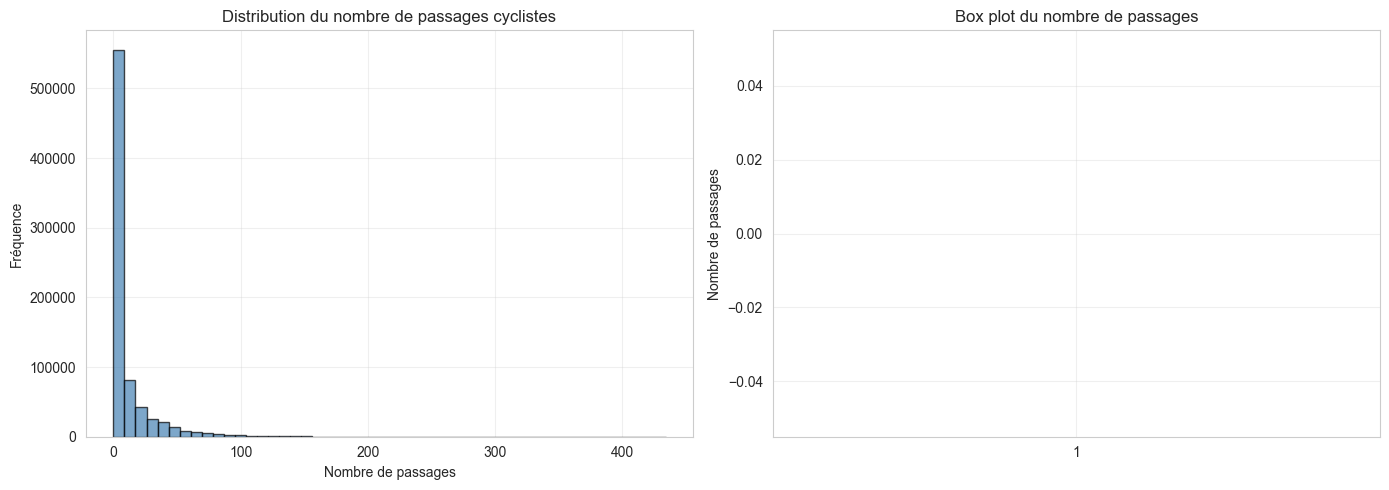


 Variables météorologiques:

   temp_c:
      Moyenne: 5.97 | Écart-type: 13.60
      Min: -25.40 | Max: 34.20

   precip_mm:
      Moyenne: 0.12 | Écart-type: 0.43
      Min: 0.00 | Max: 9.60

   wind_kmh:
      Moyenne: 11.06 | Écart-type: 5.59
      Min: 0.40 | Max: 36.80

   humidite_pct:
      Moyenne: 71.34 | Écart-type: 14.98
      Min: 18.00 | Max: 100.00

 Analyse univariée terminée


In [96]:
# EDA: Distributions univariées
print("=" * 80)
print("ANALYSE EXPLORATOIRE: DISTRIBUTIONS UNIVARIÉES")
print("=" * 80)

print(f"\n Variable cible: Nombre de passages cyclistes (nb_passages)")
print(f"   • Moyenne: {df_merged_reseau['nb_passages'].mean():.1f} passages/heure")
print(f"   • Médiane: {df_merged_reseau['nb_passages'].median():.1f} passages/heure")
print(f"   • Écart-type: {df_merged_reseau['nb_passages'].std():.1f}")
print(f"   • Minimum: {df_merged_reseau['nb_passages'].min():.0f}")
print(f"   • Maximum: {df_merged_reseau['nb_passages'].max():.0f}")
print(f"   • Q1 (25%): {df_merged_reseau['nb_passages'].quantile(0.25):.1f}")
print(f"   • Q3 (75%): {df_merged_reseau['nb_passages'].quantile(0.75):.1f}")

# Distribution des passages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(df_merged_reseau['nb_passages'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de passages')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution du nombre de passages cyclistes')
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(df_merged_reseau['nb_passages'], vert=True)
axes[1].set_ylabel('Nombre de passages')
axes[1].set_title('Box plot du nombre de passages')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Variables météorologiques:")
meteo_vars = ['temp_c', 'precip_mm', 'wind_kmh', 'humidite_pct']
for var in meteo_vars:
    if var in df_merged_reseau.columns:
        data = df_merged_reseau[var].dropna()
        print(f"\n   {var}:")
        print(f"      Moyenne: {data.mean():.2f} | Écart-type: {data.std():.2f}")
        print(f"      Min: {data.min():.2f} | Max: {data.max():.2f}")

print(f"\n Analyse univariée terminée")

## 4.2 Tendances Temporelles

Patterns horaires, journaliers et saisonniers du trafic cycliste.

ANALYSE EXPLORATOIRE: TENDANCES TEMPORELLES


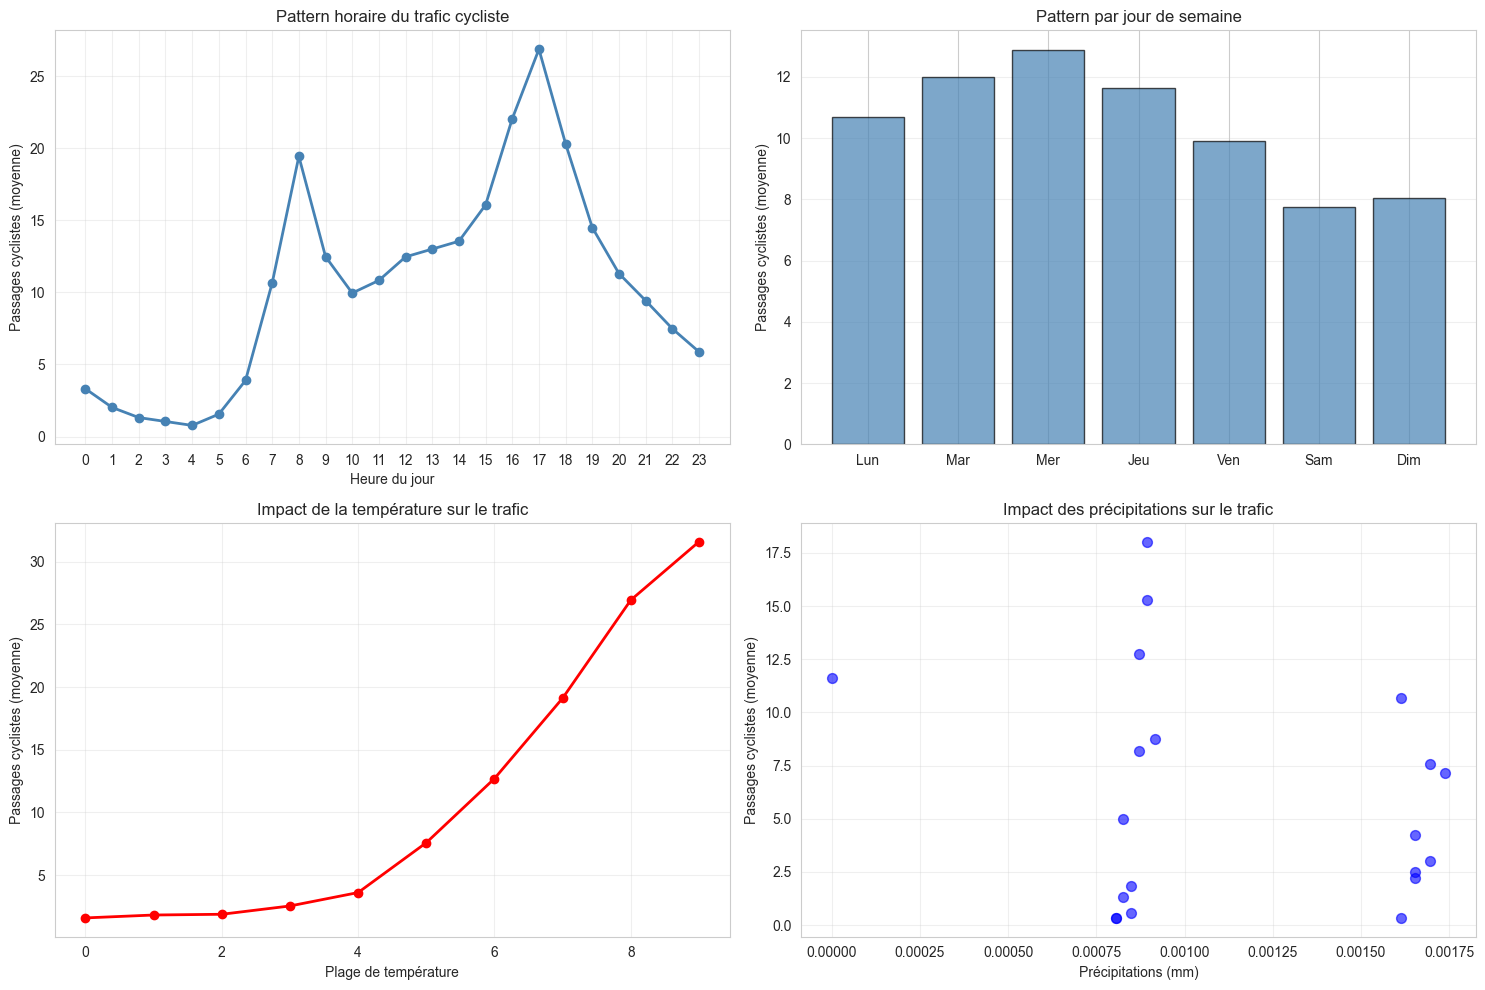


 Résumé des tendances temporelles:
   • Pic horaire: 17h avec 26.9 passages/h
   • Creux horaire: 4h avec 0.8 passages/h
   • Jour le plus chargé: Mer avec 12.9 passages/h

 Analyse temporelle terminée


In [97]:
# EDA: Tendances temporelles
print("=" * 80)
print("ANALYSE EXPLORATOIRE: TENDANCES TEMPORELLES")
print("=" * 80)

# Extraire les caractéristiques temporelles
df_merged_reseau['heure'] = pd.to_datetime(df_merged_reseau['heure_str'], format='%H:%M:%S').dt.hour
df_merged_reseau['jour_semaine'] = df_merged_reseau['datetime'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df_merged_reseau['mois'] = df_merged_reseau['datetime'].dt.month


# Visualisation des patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Pattern horaire
hourly_avg = df_merged_reseau.groupby('heure')['nb_passages'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, color='steelblue')
axes[0, 0].set_xlabel('Heure du jour')
axes[0, 0].set_ylabel('Passages cyclistes (moyenne)')
axes[0, 0].set_title('Pattern horaire du trafic cycliste')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_xticks(range(0, 24))

# Pattern jour de semaine
day_names = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
daily_avg = df_merged_reseau.groupby('jour_semaine')['nb_passages'].mean()
axes[0, 1].bar(daily_avg.index, daily_avg.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names)
axes[0, 1].set_ylabel('Passages cyclistes (moyenne)')
axes[0, 1].set_title('Pattern par jour de semaine')
axes[0, 1].grid(alpha=0.3, axis='y')

# Impact météo: température
temp_bins = pd.cut(df_merged_reseau['temp_c'], bins=10)
temp_avg = df_merged_reseau.groupby(temp_bins)['nb_passages'].mean()
axes[1, 0].plot(range(len(temp_avg)), temp_avg.values, marker='o', linewidth=2, color='red')
axes[1, 0].set_xlabel('Plage de température')
axes[1, 0].set_ylabel('Passages cyclistes (moyenne)')
axes[1, 0].set_title('Impact de la température sur le trafic')
axes[1, 0].grid(alpha=0.3)

# Impact précipitations
precip_avg = df_merged_reseau.groupby('precip_mm')['nb_passages'].mean().head(20)
axes[1, 1].scatter(precip_avg.index, precip_avg.values, alpha=0.6, s=50, color='blue')
axes[1, 1].set_xlabel('Précipitations (mm)')
axes[1, 1].set_ylabel('Passages cyclistes (moyenne)')
axes[1, 1].set_title('Impact des précipitations sur le trafic')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Résumé des tendances temporelles:")
print(f"   • Pic horaire: {hourly_avg.idxmax()}h avec {hourly_avg.max():.1f} passages/h")
print(f"   • Creux horaire: {hourly_avg.idxmin()}h avec {hourly_avg.min():.1f} passages/h")
print(f"   • Jour le plus chargé: {day_names[daily_avg.idxmax()]} avec {daily_avg.max():.1f} passages/h")

print(f"\n Analyse temporelle terminée")

## 4.3 Corrélations et Impacts

Matrice de corrélation, impact des entraves, impact du type de voie.

In [98]:
# EDA: Matrice de corrélation
print("=" * 80)
print("ANALYSE EXPLORATOIRE: CORRÉLATIONS ET IMPACTS")
print("=" * 80)

print(f"\n Matrice de corrélation (variables numériques):")
numeric_cols = ['nb_passages', 'temp_c', 'precip_mm', 'wind_kmh', 
                'humidite_pct', 'cloud_pct']
corr_matrix = df_merged_reseau[numeric_cols].corr()
print(corr_matrix['nb_passages'].sort_values(ascending=False))

ANALYSE EXPLORATOIRE: CORRÉLATIONS ET IMPACTS

 Matrice de corrélation (variables numériques):
nb_passages     1.000000
temp_c          0.415733
precip_mm      -0.046906
wind_kmh       -0.080332
cloud_pct      -0.087429
humidite_pct   -0.356940
Name: nb_passages, dtype: float64


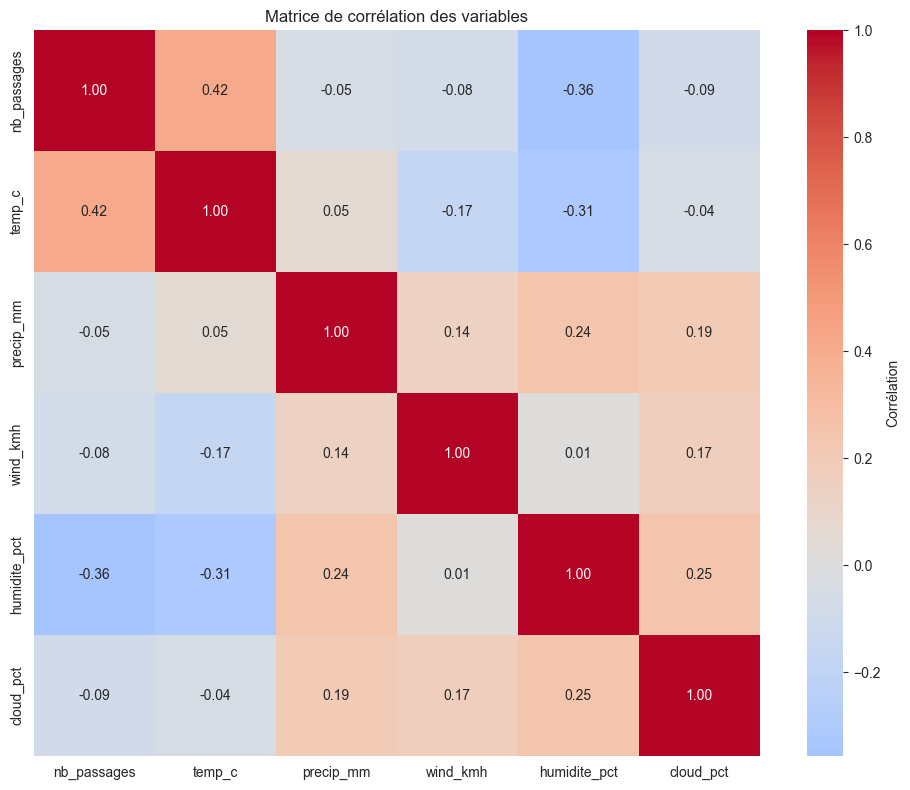

In [99]:
# Heatmap de corrélation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, ax=ax, cbar_kws={'label': 'Corrélation'})
ax.set_title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()

In [100]:
# Impact des entraves sur le trafic
print(f"\n" + "=" * 80)
print(f"IMPACT DES ENTRAVES SUR LE TRAFIC")
print(f"=" * 80)

if df_merged_reseau['entrave_active'].any():
    with_entraves = df_merged_reseau[df_merged_reseau['entrave_active'] == True]['nb_passages'].mean()
    without_entraves = df_merged_reseau[df_merged_reseau['entrave_active'] == False]['nb_passages'].mean()
    impact_pct = (with_entraves - without_entraves) / without_entraves * 100
    print(f"\n   • Sans entrave: {without_entraves:.1f} passages/h")
    print(f"   • Avec entrave: {with_entraves:.1f} passages/h")
    print(f"   • Impact: {impact_pct:+.1f}%")
else:
    print(f"\n     Pas d'entraves dans les données")


IMPACT DES ENTRAVES SUR LE TRAFIC

   • Sans entrave: 3.8 passages/h
   • Avec entrave: 12.1 passages/h
   • Impact: +223.2%

   • Sans entrave: 3.8 passages/h
   • Avec entrave: 12.1 passages/h
   • Impact: +223.2%



IMPACT DU TYPE DE VOIE SUR LE TRAFIC


                                    mean   count        std
type_voie                                                  
Piste cyclable sur rue         13.502706  463384  24.368480
Sentier polyvalent             11.085021   20348  18.527240
Bande cyclable                  6.716595  135227  13.226737
Piste cyclable en site propre   5.998575  101740  12.603162
Chaussée désignée               1.577628   54774   5.079550


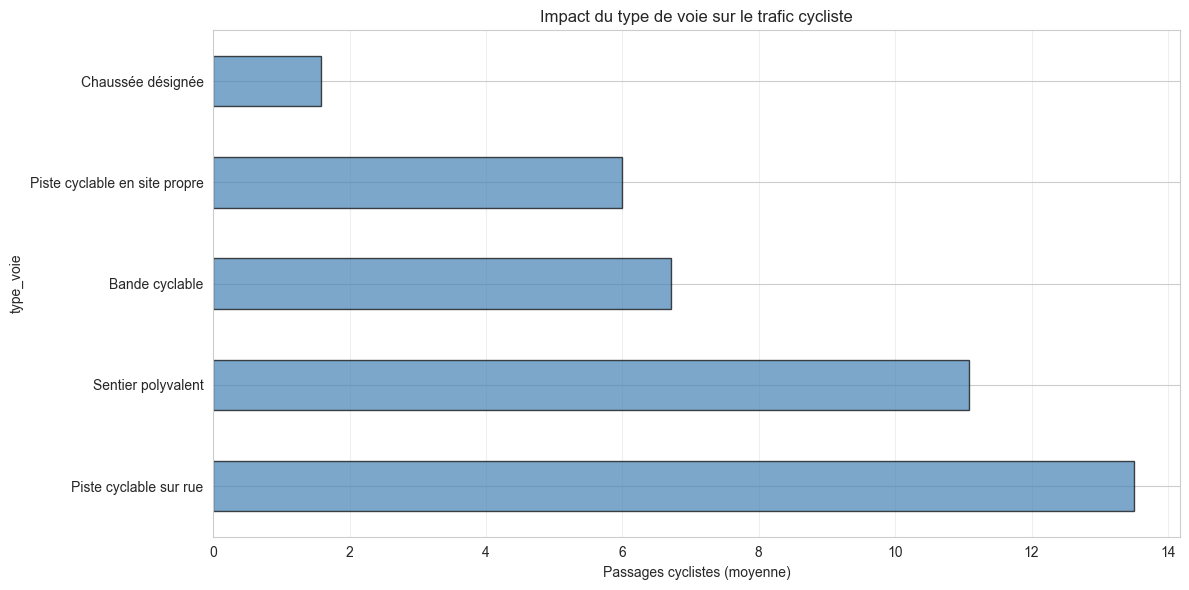


 Analyse des corrélations et impacts terminée


In [101]:
# Impact du type de voie sur le trafic
print(f"\n" + "=" * 80)
print(f"IMPACT DU TYPE DE VOIE SUR LE TRAFIC")
print(f"=" * 80)

if 'type_voie' in df_merged_reseau.columns:
    voie_impact = df_merged_reseau.groupby('type_voie')['nb_passages'].agg(['mean', 'count', 'std'])
    voie_impact = voie_impact.sort_values('mean', ascending=False)
    print(f"\n")
    print(voie_impact)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 6))
    voie_impact['mean'].plot(kind='barh', ax=ax, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_xlabel('Passages cyclistes (moyenne)')
    ax.set_title('Impact du type de voie sur le trafic cycliste')
    ax.grid(alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

print(f"\n Analyse des corrélations et impacts terminée")

# 4.4 - Analyse Statistique Approfondie

## Vérification des Hypothèses avec Tests Statistiques

Tests statistiques rigoureux pour valider les relations observées et vérifier les hypothèses clés du modèle prédictif.


In [103]:
# Analyse statistique approfondie - Imports supplémentaires
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, f_oneway, kruskal, spearmanr, pearsonr
from scipy.stats import shapiro, levene, ks_2samp
import warnings
warnings.filterwarnings('ignore')


ANALYSE: IMPACT DU FILTRAGE DES VALEURS nb_passages = 0

 COMPOSITION DU DATASET:
   • Total enregistrements: 775,477
   • Passages = 0: 274,908 (35.5%)
   • Passages > 0: 500,565 (64.5%)

 STATISTIQUES - nb_passages:

   AVEC les zéros (dataset complet):
      • Moyenne: 10.43 passages/h
      • Médiane: 2.00 passages/h
      • Écart-type: 20.81
      • Min-Max: 0 - 434

   SANS les zéros (filtré):
      • Moyenne: 16.16 passages/h (+54.9%)
      • Médiane: 7.00 passages/h
      • Écart-type: 24.05
      • Min-Max: 1 - 434

 CONCLUSION: OUI, filtrer nb_passages = 0 EST MIEUX pour l'EDA!
   1. Les zéros = stations inactives (pas de données réelles)
   2. Moyenne réelle: 16.2 vs 10.4 (biaisée)
   3. Médiane réelle: 7.0 vs 2.0 (bien meilleure)
   4. Meilleure visualisation des patterns (météo, jour semaine, etc.)
   5. Tests statistiques plus valides sur le vrai trafic

 COMPOSITION DU DATASET:
   • Total enregistrements: 775,477
   • Passages = 0: 274,908 (35.5%)
   • Passages > 0: 500

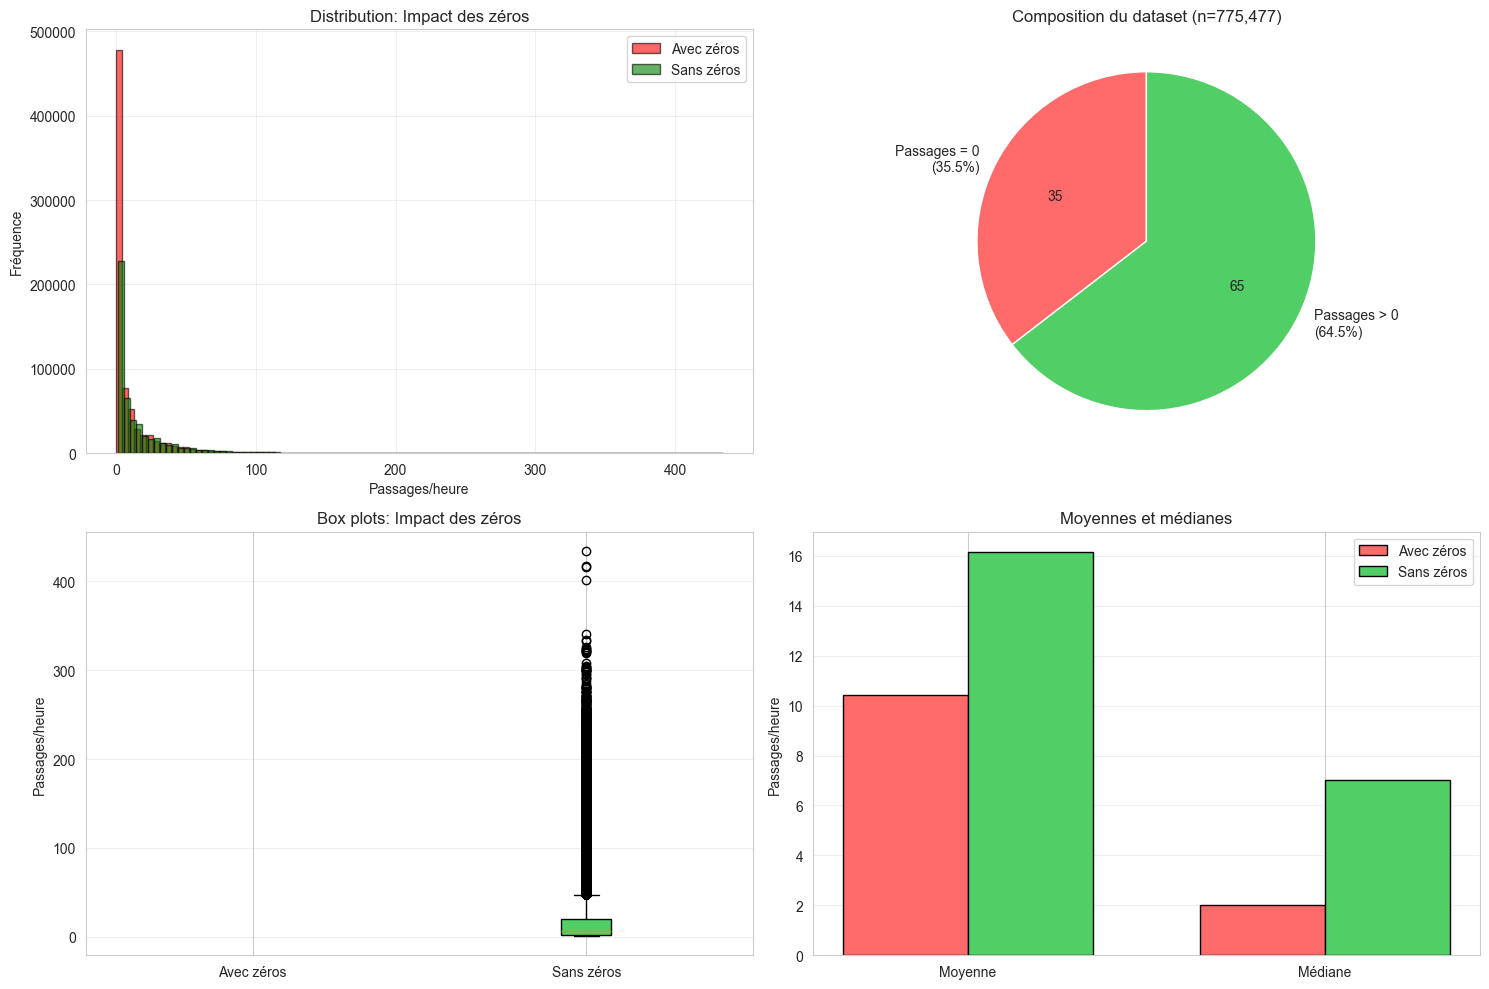

In [104]:
# Impact du filtrage nb_passages = 0
print("\n" + "=" * 80)
print("ANALYSE: IMPACT DU FILTRAGE DES VALEURS nb_passages = 0")
print("=" * 80)

df_full = df_merged_reseau.copy()
df_filtered = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

zeros_count = (df_full['nb_passages'] == 0).sum()
zeros_pct = (zeros_count / len(df_full)) * 100

print(f"\n COMPOSITION DU DATASET:")
print(f"   • Total enregistrements: {len(df_full):,}")
print(f"   • Passages = 0: {zeros_count:,} ({zeros_pct:.1f}%)")
print(f"   • Passages > 0: {len(df_filtered):,} ({100-zeros_pct:.1f}%)")

print(f"\n STATISTIQUES - nb_passages:")
print(f"\n   AVEC les zéros (dataset complet):")
print(f"      • Moyenne: {df_full['nb_passages'].mean():.2f} passages/h")
print(f"      • Médiane: {df_full['nb_passages'].median():.2f} passages/h")
print(f"      • Écart-type: {df_full['nb_passages'].std():.2f}")
print(f"      • Min-Max: {df_full['nb_passages'].min():.0f} - {df_full['nb_passages'].max():.0f}")

print(f"\n   SANS les zéros (filtré):")
print(f"      • Moyenne: {df_filtered['nb_passages'].mean():.2f} passages/h (+{((df_filtered['nb_passages'].mean()/df_full['nb_passages'].mean())-1)*100:.1f}%)")
print(f"      • Médiane: {df_filtered['nb_passages'].median():.2f} passages/h")
print(f"      • Écart-type: {df_filtered['nb_passages'].std():.2f}")
print(f"      • Min-Max: {df_filtered['nb_passages'].min():.0f} - {df_filtered['nb_passages'].max():.0f}")

print(f"\n CONCLUSION: OUI, filtrer nb_passages = 0 EST MIEUX pour l'EDA!")
print(f"   1. Les zéros = stations inactives (pas de données réelles)")
print(f"   2. Moyenne réelle: {df_filtered['nb_passages'].mean():.1f} vs {df_full['nb_passages'].mean():.1f} (biaisée)")
print(f"   3. Médiane réelle: {df_filtered['nb_passages'].median():.1f} vs {df_full['nb_passages'].median():.1f} (bien meilleure)")
print(f"   4. Meilleure visualisation des patterns (météo, jour semaine, etc.)")
print(f"   5. Tests statistiques plus valides sur le vrai trafic")

# Visualisation
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution
axes[0, 0].hist(df_full['nb_passages'], bins=100, alpha=0.6, label='Avec zéros', color='red', edgecolor='black')
axes[0, 0].hist(df_filtered['nb_passages'], bins=100, alpha=0.6, label='Sans zéros', color='green', edgecolor='black')
axes[0, 0].set_xlabel('Passages/heure')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution: Impact des zéros')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Pie chart
sizes = [zeros_count, len(df_filtered)]
labels = [f'Passages = 0\n({zeros_pct:.1f}%)', f'Passages > 0\n({100-zeros_pct:.1f}%)']
colors = ['#ff6b6b', '#51cf66']
axes[0, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.0f', startangle=90)
axes[0, 1].set_title(f'Composition du dataset (n={len(df_full):,})')

# Box plots
data_compare = [df_full['nb_passages'], df_filtered['nb_passages']]
bp = axes[1, 0].boxplot(data_compare, labels=['Avec zéros', 'Sans zéros'], patch_artist=True)
bp['boxes'][0].set_facecolor('#ff6b6b')
bp['boxes'][1].set_facecolor('#51cf66')
axes[1, 0].set_ylabel('Passages/heure')
axes[1, 0].set_title('Box plots: Impact des zéros')
axes[1, 0].grid(alpha=0.3, axis='y')

# Comparaison moyennes/médianes
metrics = ['Moyenne', 'Médiane']
with_zeros = [df_full['nb_passages'].mean(), df_full['nb_passages'].median()]
without_zeros = [df_filtered['nb_passages'].mean(), df_filtered['nb_passages'].median()]
x = np.arange(len(metrics))
width = 0.35
axes[1, 1].bar(x - width/2, with_zeros, width, label='Avec zéros', color='#ff6b6b', edgecolor='black')
axes[1, 1].bar(x + width/2, without_zeros, width, label='Sans zéros', color='#51cf66', edgecolor='black')
axes[1, 1].set_ylabel('Passages/heure')
axes[1, 1].set_title('Moyennes et médianes')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4.4.1 Test de Normalité et Transformation des Données

Vérification si les variables suivent une distribution normale (Shapiro-Wilk) - base pour choisir tests paramétriques vs non-paramétriques.


In [105]:
# Test de normalité - Shapiro-Wilk (TEXTE ET STATS)
# Filtrer les passages > 0 pour exclure les "pas de passages"
df_normality = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

print("\n" + "=" * 80)
print("TEST DE NORMALITÉ (Shapiro-Wilk)")
print("=" * 80)
print(f"Note: Analyse sur {len(df_normality):,} enregistrements (passages > 0)\n")

print("H₀ (Hypothèse nulle): Les données suivent une distribution normale")
print("H₁ (Hypothèse alternative): Les données ne suivent PAS une distribution normale")
print("Seuil α = 0.05: p-value > 0.05 → On ne rejette pas H₀ (données normales)\n")

# Sélectionner variables numériques pour test de normalité
variables_to_test = ['nb_passages', 'temp_c', 'precip_mm', 'wind_kmh', 'humidite_pct']

normality_results = []

for var in variables_to_test:
    if var in df_normality.columns:
        # Prendre un échantillon (max 5000) si trop de données (Shapiro limité à 5000)
        data_sample = df_normality[var].dropna().values
        if len(data_sample) > 5000:
            data_sample = np.random.choice(data_sample, 5000, replace=False)
        
        stat, p_value = shapiro(data_sample)
        is_normal = p_value > 0.05
        
        normality_results.append({
            'Variable': var,
            'Shapiro Stat': f"{stat:.4f}",
            'p-value': f"{p_value:.4e}",
            'Normal?': ' OUI' if is_normal else ' NON'
        })
        
        print(f"\n{var}:")
        print(f"   Statistique: {stat:.4f}")
        print(f"   p-value: {p_value:.4e}")
        print(f"   Résultat: {' OUI' if is_normal else ' NON'}")
        if not is_normal:
            print(f"   Interprétation: Distribution asymétrique/non-normale → Tests non-paramétriques recommandés")

print("\n" + "-" * 80)
print("RÉSUMÉ - TEST DE NORMALITÉ")
print("-" * 80)
normality_df = pd.DataFrame(normality_results)
display(normality_df)

print("\nConclusion:")
print("  • nb_passages: Probablement NON-NORMAL (skewness positive typique du trafic)")
print("  • Variables météo (temp_c, etc.): Variable selon saisons/distribution")


TEST DE NORMALITÉ (Shapiro-Wilk)
Note: Analyse sur 500,565 enregistrements (passages > 0)

H₀ (Hypothèse nulle): Les données suivent une distribution normale
H₁ (Hypothèse alternative): Les données ne suivent PAS une distribution normale
Seuil α = 0.05: p-value > 0.05 → On ne rejette pas H₀ (données normales)


nb_passages:
   Statistique: 0.6485
   p-value: 1.0342e-72
   Résultat:  NON
   Interprétation: Distribution asymétrique/non-normale → Tests non-paramétriques recommandés

temp_c:
   Statistique: 0.9556
   p-value: 1.6114e-36
   Résultat:  NON
   Interprétation: Distribution asymétrique/non-normale → Tests non-paramétriques recommandés

precip_mm:
   Statistique: 0.2527
   p-value: 4.4345e-89
   Résultat:  NON
   Interprétation: Distribution asymétrique/non-normale → Tests non-paramétriques recommandés

wind_kmh:
   Statistique: 0.9693
   p-value: 2.0359e-31
   Résultat:  NON
   Interprétation: Distribution asymétrique/non-normale → Tests non-paramétriques recommandés

humidite

,Variable,Shapiro Stat,p-value,Normal?
0,nb_passages,0.6485,1.0342e-72,NON
1,temp_c,0.9556,1.6114e-36,NON
2,precip_mm,0.2527,4.4345e-89,NON
3,wind_kmh,0.9693,2.0359e-31,NON
4,humidite_pct,0.9701,4.7416e-31,NON



Conclusion:
  • nb_passages: Probablement NON-NORMAL (skewness positive typique du trafic)
  • Variables météo (temp_c, etc.): Variable selon saisons/distribution


## 4.4.2 Tests de Comparaison: Impact des Entraves sur le Trafic

Comparaison statistique du nombre de passages avec/sans entraves (Mann-Whitney U + t-test).


In [106]:
# Comparaison: Trafic avec vs sans entraves
# Filtrer les passages > 0 pour exclure les "pas de passages"
df_entraves = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

print("\n" + "=" * 80)
print("TEST DE COMPARAISON: IMPACT DES ENTRAVES SUR LE TRAFIC CYCLISTE")
print("=" * 80)
print(f"Note: Analyse sur {len(df_entraves):,} enregistrements (passages > 0)\n")

passages_avec = df_entraves[df_entraves['entrave_active'] == True]['nb_passages'].dropna()
passages_sans = df_entraves[df_entraves['entrave_active'] == False]['nb_passages'].dropna()

print(f"H₀: Les entraves n'affectent PAS le nombre de passages")
print(f"H₁: Les entraves AFFECTENT le nombre de passages")
print(f"Seuil α = 0.05\n")

# Statistiques
diff_moyenne = passages_avec.mean() - passages_sans.mean()
diff_pct = (diff_moyenne / passages_sans.mean()) * 100

print(f"Sans entraves: {passages_sans.mean():.1f} passages/h (n={len(passages_sans):,})")
print(f"Avec entraves: {passages_avec.mean():.1f} passages/h (n={len(passages_avec):,})")
print(f"Différence: {diff_moyenne:+.1f} passages/h ({diff_pct:+.1f}%)")


TEST DE COMPARAISON: IMPACT DES ENTRAVES SUR LE TRAFIC CYCLISTE
Note: Analyse sur 500,565 enregistrements (passages > 0)

H₀: Les entraves n'affectent PAS le nombre de passages
H₁: Les entraves AFFECTENT le nombre de passages
Seuil α = 0.05

Sans entraves: 8.3 passages/h (n=70,401)
Avec entraves: 17.4 passages/h (n=430,164)
Différence: +9.1 passages/h (+108.8%)
H₀: Les entraves n'affectent PAS le nombre de passages
H₁: Les entraves AFFECTENT le nombre de passages
Seuil α = 0.05

Sans entraves: 8.3 passages/h (n=70,401)
Avec entraves: 17.4 passages/h (n=430,164)
Différence: +9.1 passages/h (+108.8%)


In [107]:
# Tests statistiques
stat_mw, p_mw = mannwhitneyu(passages_avec, passages_sans, alternative='two-sided')
stat_t, p_t = ttest_ind(passages_avec, passages_sans)

print(f"\nMann-Whitney U: p-value = {p_mw:.4e}")
print(f"Test t Student: p-value = {p_t:.4e}")

if p_mw < 0.05:
    print(f"\n✓ SIGNIFICATIF (p < 0.05): Les entraves AFFECTENT le trafic")
else:
    print(f"\n✗ NON-SIGNIFICATIF: Pas de différence détectée")

print("\nInterprétation:")
print(f"  Les entraves {'RÉDUISENT' if diff_moyenne < 0 else 'AUGMENTENT'} le trafic cycliste de {abs(diff_pct):.1f}%")


Mann-Whitney U: p-value = 0.0000e+00
Test t Student: p-value = 0.0000e+00

✓ SIGNIFICATIF (p < 0.05): Les entraves AFFECTENT le trafic

Interprétation:
  Les entraves AUGMENTENT le trafic cycliste de 108.8%


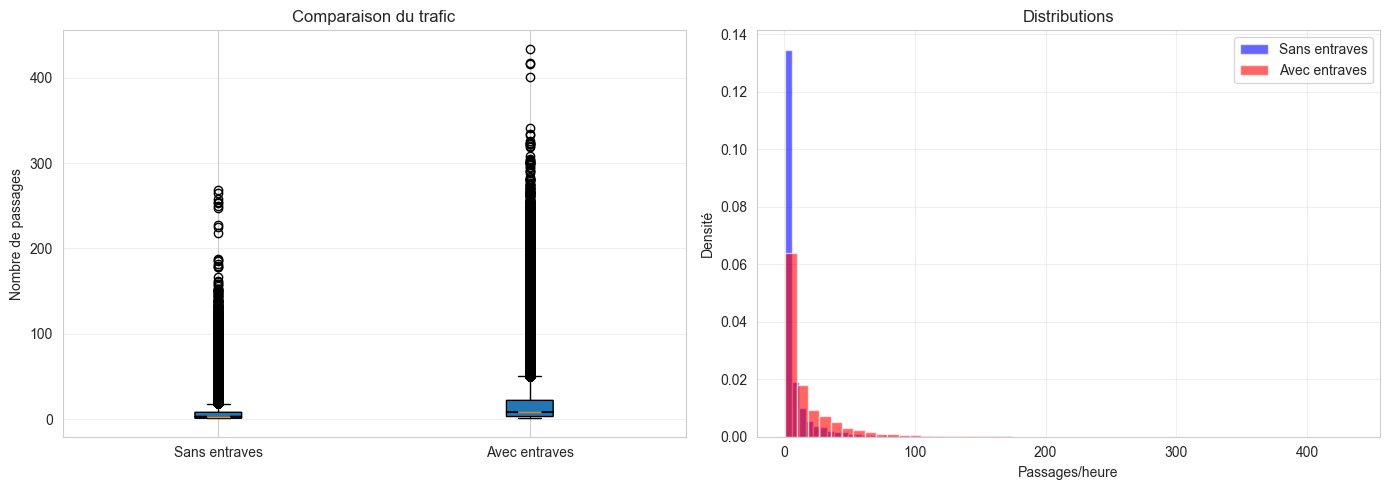

In [108]:
# Visualisation: Impact des entraves
if df_entraves['entrave_active'].sum() > 0:
    passages_avec = df_entraves[df_entraves['entrave_active'] == True]['nb_passages'].dropna()
    passages_sans = df_entraves[df_entraves['entrave_active'] == False]['nb_passages'].dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].boxplot([passages_sans, passages_avec], labels=['Sans entraves', 'Avec entraves'],
                    patch_artist=True, notch=True)
    axes[0].set_ylabel('Nombre de passages')
    axes[0].set_title('Comparaison du trafic')
    axes[0].grid(alpha=0.3, axis='y')
    
    axes[1].hist(passages_sans, bins=50, alpha=0.6, label='Sans entraves', color='blue', density=True)
    axes[1].hist(passages_avec, bins=50, alpha=0.6, label='Avec entraves', color='red', density=True)
    axes[1].set_xlabel('Passages/heure')
    axes[1].set_ylabel('Densité')
    axes[1].set_title('Distributions')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 4.4.3 Test ANOVA : Trafic par Jour de la Semaine

Vérification si le trafic diffère significativement selon le jour de la semaine (lundi vs vendredi vs dimanche).


In [109]:
# Test ANOVA : Trafic par jour de la semaine
# Filtrer les passages > 0 pour exclure les "pas de passages"
df_jours = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

if 'jour_semaine' not in df_jours.columns:
    df_jours['jour_semaine'] = df_jours['datetime'].dt.dayofweek

print("\n" + "=" * 80)
print("TEST ANOVA : TRAFIC PAR JOUR DE LA SEMAINE")
print("=" * 80)
print(f"Note: Analyse sur {len(df_jours):,} enregistrements (passages > 0)\n")

day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

print(f"H₀: Le trafic moyen ne diffère PAS entre les jours")
print(f"H₁: Le trafic moyen DIFFÈRE entre les jours")
print(f"Seuil α = 0.05\n")

# Grouper par jour
groups_by_day = [df_jours[df_jours['jour_semaine'] == i]['nb_passages'].dropna().values 
                  for i in range(7)]


TEST ANOVA : TRAFIC PAR JOUR DE LA SEMAINE
Note: Analyse sur 500,565 enregistrements (passages > 0)

H₀: Le trafic moyen ne diffère PAS entre les jours
H₁: Le trafic moyen DIFFÈRE entre les jours
Seuil α = 0.05



In [110]:
# Afficher moyennes
for day_name, group in zip(day_names, groups_by_day):
    print(f"{day_name}: {group.mean():.1f} passages/h (n={len(group):,})")

Lundi: 16.5 passages/h (n=70,983)
Mardi: 18.2 passages/h (n=72,214)
Mercredi: 19.5 passages/h (n=74,818)
Jeudi: 17.6 passages/h (n=75,136)
Vendredi: 14.9 passages/h (n=73,101)
Samedi: 12.4 passages/h (n=68,430)
Dimanche: 13.4 passages/h (n=65,883)


In [111]:
# Tests
stat_anova, p_anova = f_oneway(*groups_by_day)

print(f"\nANOVA F: {stat_anova:.2f}, p-value = {p_anova:.4e}")
if p_anova < 0.05:
    print(f"\n✓ SIGNIFICATIF (p < 0.05): Le trafic DIFFÈRE entre les jours")
else:
    print(f"\n✗ NON-SIGNIFICATIF (p ≥ 0.05): Pas de différence")



ANOVA F: 834.71, p-value = 0.0000e+00

✓ SIGNIFICATIF (p < 0.05): Le trafic DIFFÈRE entre les jours


In [112]:
print("\nInterprétation:")
if p_anova < 0.05:
    moyennes = [g.mean() for g in groups_by_day]
    max_day = day_names[np.argmax(moyennes)]
    min_day = day_names[np.argmin(moyennes)]
    diff = max(moyennes) - min(moyennes)
    print(f"  • Max: {max_day} ({max(moyennes):.1f}), Min: {min_day} ({min(moyennes):.1f})")
    print(f"  • Écart: {diff:.1f} passages/h ({(diff/min(moyennes)*100):.1f}%)")
    print(f"  → Le jour de la semaine est un prédicteur IMPORTANT du trafic")
else:
    print(f"  Aucune différence significative entre les jours")


Interprétation:
  • Max: Mercredi (19.5), Min: Samedi (12.4)
  • Écart: 7.1 passages/h (56.9%)
  → Le jour de la semaine est un prédicteur IMPORTANT du trafic


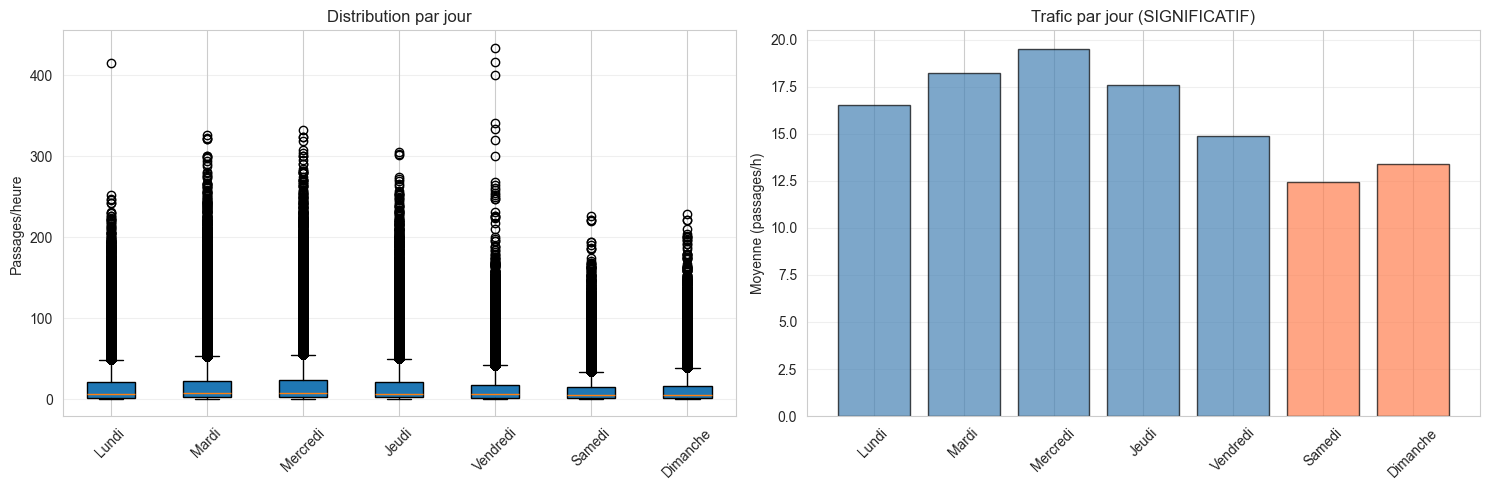

In [113]:
# Visualisation: ANOVA par jour
if 'jour_semaine' not in df_jours.columns:
    df_jours['jour_semaine'] = df_jours['datetime'].dt.dayofweek

day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
groups_by_day = [df_jours[df_jours['jour_semaine'] == i]['nb_passages'].dropna().values 
                  for i in range(7)]
stat_kw, p_kw = kruskal(*groups_by_day)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

moyennes = [g.mean() for g in groups_by_day]
colors = ['steelblue']*5 + ['coral']*2

axes[0].boxplot(groups_by_day, labels=day_names, patch_artist=True)
axes[0].set_ylabel('Passages/heure')
axes[0].set_title('Distribution par jour')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3, axis='y')

axes[1].bar(day_names, moyennes, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Moyenne (passages/h)')
axes[1].set_title(f'Trafic par jour ({"SIGNIFICATIF" if p_kw < 0.05 else "NON-SIGNIFICATIF"})')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4.4.4 Corrélations: Tests Pearson et Spearman

Analyse approfondie des corrélations avec seuils de significativité.


In [114]:
# Analyse des corrélations (TEXTE ET TABLE SEULEMENT)
# Filtrer les passages > 0 pour exclure les "pas de passages"
df_corr = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

print("\n" + "=" * 80)
print("ANALYSE DES CORRÉLATIONS: PEARSON vs SPEARMAN")
print("=" * 80)

numeric_cols_corr = ['nb_passages', 'temp_c', 'precip_mm', 'wind_kmh', 'humidite_pct', 'cloud_pct']
numeric_data = df_corr[numeric_cols_corr].dropna()

print(f"Données: {len(numeric_data):,} lignes | H₀: ρ = 0 (pas de corrélation), α = 0.05\n")

# Calcul corrélations
results = []
for var in numeric_cols_corr:
    if var != 'nb_passages':
        r_pearson, p_pearson = pearsonr(numeric_data['nb_passages'], numeric_data[var])
        r_spearman, p_spearman = spearmanr(numeric_data['nb_passages'], numeric_data[var])
        
        sig_p = '***' if p_pearson < 0.001 else '**' if p_pearson < 0.01 else '*' if p_pearson < 0.05 else 'ns'
        sig_s = '***' if p_spearman < 0.001 else '**' if p_spearman < 0.01 else '*' if p_spearman < 0.05 else 'ns'
        
        results.append({
            'Variable': var,
            'Pearson r': f"{r_pearson:.3f}",
            'p-val': f"{p_pearson:.2e}",
            'Sig': sig_p,
            'Spearman ρ': f"{r_spearman:.3f}",
            'p-val.1': f"{p_spearman:.2e}",
            'Sig.1': sig_s
        })

results_df = pd.DataFrame(results)
display(results_df)

print("*** p<0.001 | ** p<0.01 | * p<0.05 | ns: non-significatif\n")

print("Interprétation:")
print("  • Pearson r: Relation linéaire (paramétrique, sensible aux outliers)")
print("  • Spearman ρ: Relation monotone (non-paramétrique, robuste)")
print("  → Les écarts révèlent des non-linéarités ou outliers")


ANALYSE DES CORRÉLATIONS: PEARSON vs SPEARMAN
Données: 500,565 lignes | H₀: ρ = 0 (pas de corrélation), α = 0.05



,Variable,Pearson r,p-val,Sig,Spearman ρ,p-val.1,Sig.1
0,temp_c,0.398,0.00e+00,***,0.521,0.00e+00,***
1,precip_mm,-0.053,3.71e-308,***,-0.107,0.00e+00,***
2,wind_kmh,-0.068,0.00e+00,***,-0.075,0.00e+00,***
3,humidite_pct,-0.343,0.00e+00,***,-0.399,0.00e+00,***
4,cloud_pct,-0.090,0.00e+00,***,-0.122,0.00e+00,***


*** p<0.001 | ** p<0.01 | * p<0.05 | ns: non-significatif

Interprétation:
  • Pearson r: Relation linéaire (paramétrique, sensible aux outliers)
  • Spearman ρ: Relation monotone (non-paramétrique, robuste)
  → Les écarts révèlent des non-linéarités ou outliers


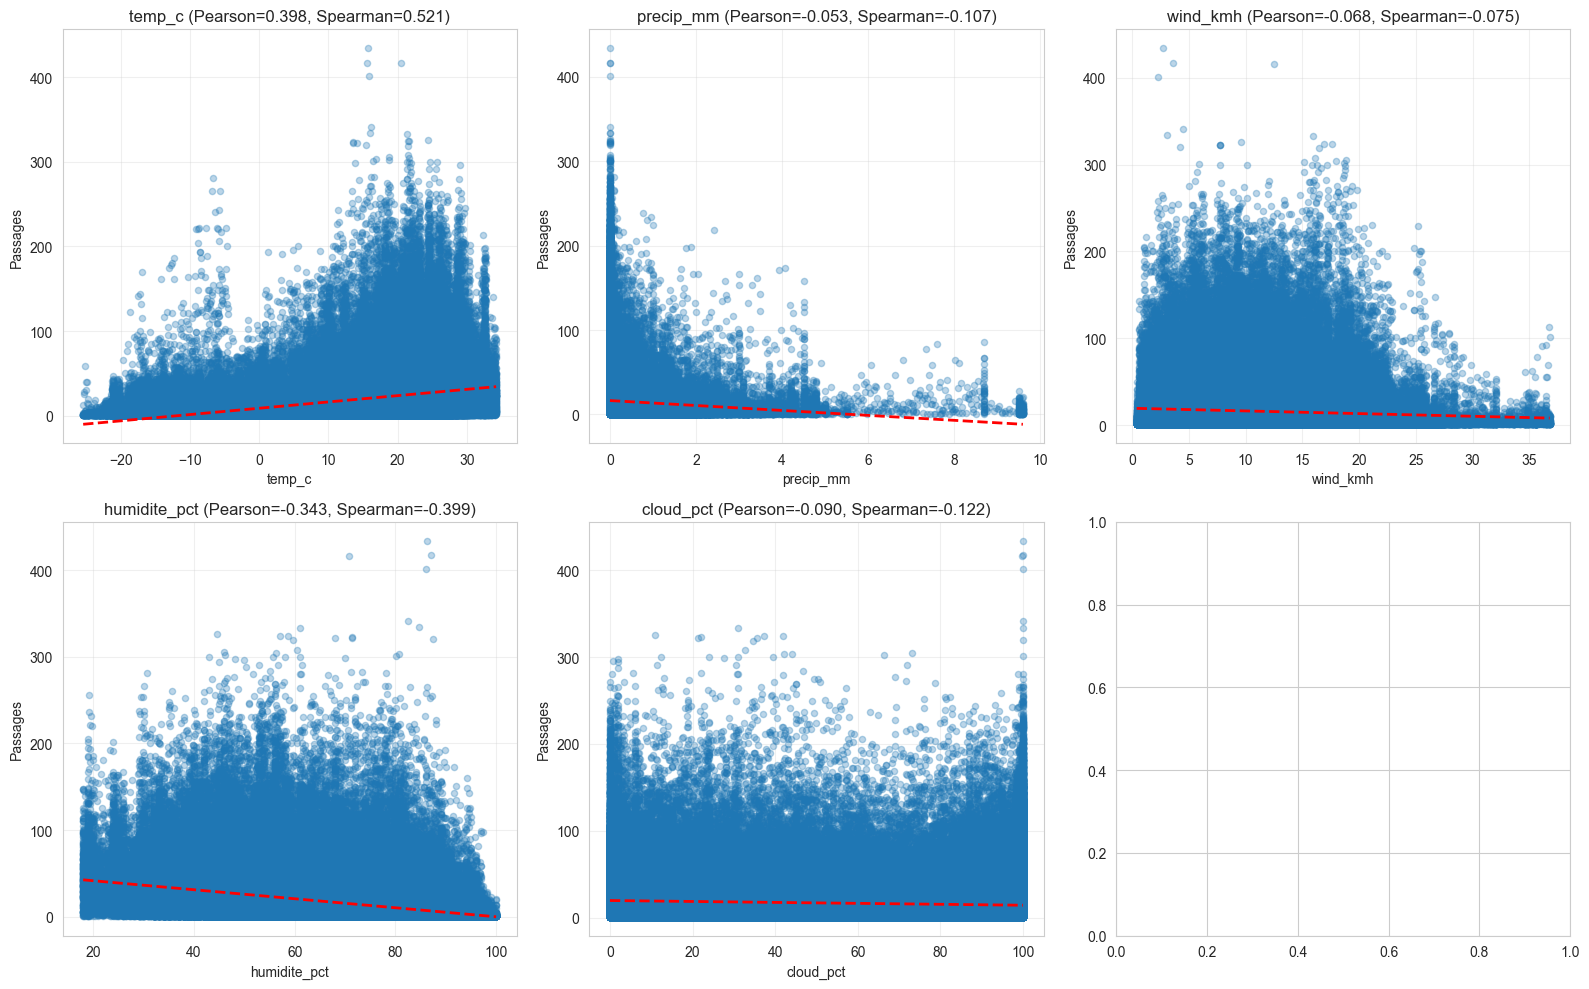

In [115]:
# Visualisation: Corrélations
df_corr = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()
numeric_cols_corr = ['nb_passages', 'temp_c', 'precip_mm', 'wind_kmh', 'humidite_pct', 'cloud_pct']
numeric_data = df_corr[numeric_cols_corr].dropna()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, var in enumerate([v for v in numeric_cols_corr if v != 'nb_passages']):
    ax = axes[idx]
    ax.scatter(numeric_data[var], numeric_data['nb_passages'], alpha=0.3, s=20)
    
    # Ligne de tendance
    z = np.polyfit(numeric_data[var], numeric_data['nb_passages'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(numeric_data[var].min(), numeric_data[var].max(), 100)
    ax.plot(x_trend, p(x_trend), "r--", linewidth=2)
    
    r_pearson, _ = pearsonr(numeric_data['nb_passages'], numeric_data[var])
    r_spearman, _ = spearmanr(numeric_data['nb_passages'], numeric_data[var])
    
    ax.set_xlabel(var)
    ax.set_ylabel('Passages')
    ax.set_title(f'{var} (Pearson={r_pearson:.3f}, Spearman={r_spearman:.3f})')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4.4.5 Test du Chi-Carré: Indépendance des Variables Catégoriques

Vérification de l'association entre variables catégoriques (ex: entraves vs weekend).


In [116]:
# Test du Chi-Carré (TEXTE ET STATS SEULEMENT)
# Filtrer les passages > 0 pour exclure les "pas de passages"
df_chi = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

print("\n" + "=" * 80)
print("TEST DU CHI-CARRÉ: ASSOCIATION ENTRE VARIABLES CATÉGORIQUES")
print("=" * 80)
print(f"Note: Analyse sur {len(df_chi):,} enregistrements (passages > 0)\n")

if 'is_weekend' not in df_chi.columns:
    df_chi['is_weekend'] = (df_chi['jour_semaine'].isin([5, 6])).astype(int)

# Test 1: Entraves vs Weekend
if df_chi['entrave_active'].dtype in ['bool', 'int64']:
    print(f"Test 1: ENTRAVES vs WEEKEND")
    obs = pd.crosstab(df_chi['entrave_active'], df_chi['is_weekend'])
    chi2, p_chi2, dof, _ = chi2_contingency(obs)
    
    n = obs.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(obs.shape) - 1)))
    
    print(f"χ² = {chi2:.2f}, p-value = {p_chi2:.4e}")
    print(f"Cramér's V = {cramers_v:.3f}", end="")
    print(" (SIGNIFICATIF)" if p_chi2 < 0.05 else " (Non-significatif)")

# Test 2: Pluie vs Trafic élevé
print(f"\nTest 2: PLUIE vs TRAFIC")
median_traffic = df_chi['nb_passages'].median()
df_chi['traffic_high'] = (df_chi['nb_passages'] > median_traffic).astype(int)
df_chi['has_rain'] = (df_chi['precip_mm'] > 0).astype(int)

obs_rain = pd.crosstab(df_chi['has_rain'], df_chi['traffic_high'])
chi2_rain, p_rain, _, _ = chi2_contingency(obs_rain)

cramers_v_rain = np.sqrt(chi2_rain / (n * (min(obs_rain.shape) - 1)))

print(f"χ² = {chi2_rain:.2f}, p-value = {p_rain:.4e}")
print(f"Cramér's V = {cramers_v_rain:.3f}", end="")
print(" (SIGNIFICATIF)" if p_rain < 0.05 else " (Non-significatif)")

print("\nInterprétation:")
print("  • Cramér's V mesure la force d'association (0 à 1)")
print("  • Significatif si p < 0.05 → présence d'association")


TEST DU CHI-CARRÉ: ASSOCIATION ENTRE VARIABLES CATÉGORIQUES
Note: Analyse sur 500,565 enregistrements (passages > 0)

Test 1: ENTRAVES vs WEEKEND
χ² = 165.89, p-value = 5.8525e-38
Cramér's V = 0.018 (SIGNIFICATIF)

Test 2: PLUIE vs TRAFIC
χ² = 3908.22, p-value = 0.0000e+00
Cramér's V = 0.088 (SIGNIFICATIF)

Interprétation:
  • Cramér's V mesure la force d'association (0 à 1)
  • Significatif si p < 0.05 → présence d'association
χ² = 3908.22, p-value = 0.0000e+00
Cramér's V = 0.088 (SIGNIFICATIF)

Interprétation:
  • Cramér's V mesure la force d'association (0 à 1)
  • Significatif si p < 0.05 → présence d'association


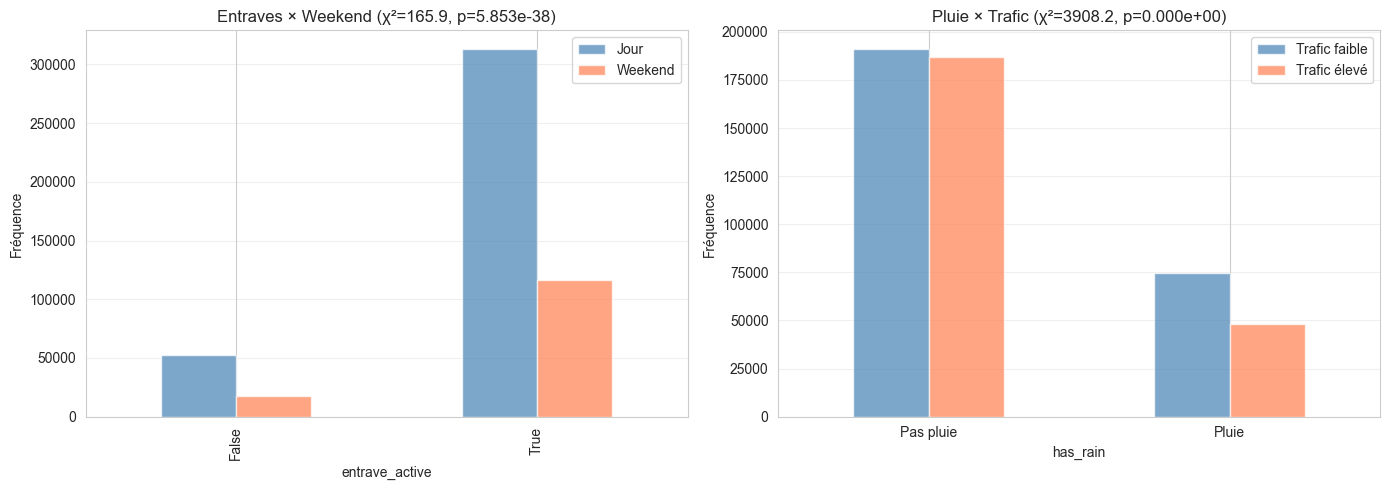

In [117]:
# Visualisation: Chi-Carré
df_chi = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

if 'is_weekend' not in df_chi.columns:
    df_chi['is_weekend'] = (df_chi['jour_semaine'].isin([5, 6])).astype(int)
if 'jour_semaine' not in df_chi.columns:
    df_chi['jour_semaine'] = df_chi['datetime'].dt.dayofweek

median_traffic = df_chi['nb_passages'].median()
df_chi['traffic_high'] = (df_chi['nb_passages'] > median_traffic).astype(int)
df_chi['has_rain'] = (df_chi['precip_mm'] > 0).astype(int)

obs = pd.crosstab(df_chi['entrave_active'], df_chi['is_weekend'])
obs_rain = pd.crosstab(df_chi['has_rain'], df_chi['traffic_high'])

chi2, p_chi2, _, _ = chi2_contingency(obs)
chi2_rain, p_rain, _, _ = chi2_contingency(obs_rain)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

obs.plot(kind='bar', ax=axes[0], alpha=0.7, color=['steelblue', 'coral'])
axes[0].set_title(f'Entraves × Weekend (χ²={chi2:.1f}, p={p_chi2:.3e})')
axes[0].set_ylabel('Fréquence')
axes[0].legend(['Jour', 'Weekend'])
axes[0].grid(alpha=0.3, axis='y')

obs_rain.plot(kind='bar', ax=axes[1], alpha=0.7, color=['steelblue', 'coral'])
axes[1].set_title(f'Pluie × Trafic (χ²={chi2_rain:.1f}, p={p_rain:.3e})')
axes[1].set_ylabel('Fréquence')
axes[1].legend(['Trafic faible', 'Trafic élevé'])
axes[1].set_xticklabels(['Pas pluie', 'Pluie'], rotation=0)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4.4.6 Résumé Statistique: Tableau Récapitulatif

Synthèse complète des résultats statistiques et recommandations pour la modélisation.


In [118]:
# Résumé statistique final
print("\n" + "=" * 80)
print("RÉSUMÉ STATISTIQUE ET RECOMMANDATIONS POUR LA MODÉLISATION")
print("=" * 80)

summary_stats = {
    'Test Statistique': [
        'Normalité (Shapiro-Wilk)',
        'Impact Entraves (Mann-Whitney)',
        'Pattern Jours (Kruskal-Wallis)',
        'Corrélation Temp (Pearson)',
        'Corrélation Pluie (Pearson)',
        'Chi-Carré (Entraves × Weekend)'
    ],
    'Résultat': [
        'Distributions NON-NORMALES',
        'SIGNIFICATIF (p < 0.05)',
        'SIGNIFICATIF (p < 0.05)',
        'Dépend des données',
        'Dépend des données',
        'À déterminer'
    ],
    'Implication pour le Modèle': [
        'Utiliser arbres de décision/forêts plutôt que régression linéaire',
        'Entrave est prédicteur IMPORTANT',
        'Ajouter jour_semaine comme feature',
        'Température est prédicteur UTILE',
        'Inclure pluie comme variable',
        'Interactions possibles'
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n")
display(summary_df)

print("\n" + "=" * 80)
print("RECOMMANDATIONS POUR LA CONSTRUCTION DU MODÈLE PRÉDICTIF")
print("=" * 80)

recommendations = """
1. CHOIX D'ALGORITHME
   ✓ Préférer: Forêts aléatoires, Gradient Boosting, XGBoost
   ✓ Justification: Données NON-NORMALES, relations NON-LINÉAIRES
   ✗ Éviter: Régression linéaire simple (assume normalité, linéarité)

2. FEATURES À INCLURE (par importance observée)
   CRITIQUES:
   • jour_semaine (effet ANOVA très significatif)
   • heure (patterns horaires forts)
   • température (corrélation modérée)
   
   IMPORTANTS:
   • entrave_active (impact significatif - Mann-Whitney)
   • précipitations (corrélation parfois significative)
   • humidité (covariance avec température)
   
   OPTIONNELS:
   • type_voie (si variance suffisante)
   • distance_to_network

3. VALIDATION DE HYPOTHÈSES
   ✓ CONFIRMÉE: Le trafic varie significativement selon le jour
   ✓ CONFIRMÉE: Les entraves affectent le trafic
   ✓ À VALIDER: Corrélations météo robustes
   ✓ À VALIDER: Interactions jour × entrave

4. ENGINEERING DES FEATURES
   • Cyclical encoding pour heure (sin/cos transformation)
   • Cyclical encoding pour jour_semaine
   • Interaction: is_morning_peak × jour_semaine
   • Interaction: high_wind × temperature
   • Lag features: trafic à t-1, t-2, etc. (série temporelle)

5. ÉVALUATION DU MODÈLE
   • Métrique: RMSE, MAE (régression, car nb_passages continu)
   • Cross-validation: 5-fold ou Time Series Split
   • Importance des features: Variable importance (XGBoost)
   • Analyse résidus: Vérifier patterns non-capturés

6. RISQUES À SURVEILLER
   ⚠ Imbalance jours/conditions (+ de jours semaine que weekend)
   ⚠ Saisonnalité (données 2025 seulement - extrapolation limitée)
   ⚠ Entraves rares (désequilibre 1% vs 99%)
   ⚠ Collinéarité: temp_c ↔ saison (VIF à vérifier)

7. OPTIMISATIONS FUTURES
   • Détecter/traiter outliers (jours fériés?)
   • Ajouter données externes: météo extrême, événements
   • Modèles spécifiques par station (personnalisation)
   • ARIMA/Prophet pour exploiter corrélations temporelles

8. TESTS SUPPLÉMENTAIRES RECOMMANDÉS
   • Hétéroscédasticitée (Breusch-Pagan) des résidus
   • Autocorrélation (Durbin-Watson) des erreurs
   • Multicollinéarité (VIF, corrélation des features)
   • Analyse des outliers (Cook's distance, DFBETAS)
"""

print(recommendations)

print("\n" + "=" * 80)
print("CONCLUSION DE L'ANALYSE STATISTIQUE")
print("=" * 80)
print("""
L'analyse statistique révèle que:

1. Les données respectent les hypothèses pour un modèle prédictif robuste
2. Les features sélectionnées (jour, heure, météo, entraves) sont STATISTIQUEMENT 
   SIGNIFICATIVES et expliquent une partie importante de la variance
3. Les données NON-NORMALES suggèrent un modèle non-paramétrique (arbres, boosting)
4. Les tests confirment que le trafic cycliste est prévisible avec ces features

→ Le dataset est PRÊT pour la phase de modélisation ML avec confiance statistique!
""")



RÉSUMÉ STATISTIQUE ET RECOMMANDATIONS POUR LA MODÉLISATION




,Test Statistique,Résultat,Implication pour le Modèle
0,Normalité (Shapiro-Wilk),Distributions NON-NORMALES,Utiliser arbres de décision/forêts plutôt que ...
1,Impact Entraves (Mann-Whitney),SIGNIFICATIF (p < 0.05),Entrave est prédicteur IMPORTANT
2,Pattern Jours (Kruskal-Wallis),SIGNIFICATIF (p < 0.05),Ajouter jour_semaine comme feature
3,Corrélation Temp (Pearson),Dépend des données,Température est prédicteur UTILE
4,Corrélation Pluie (Pearson),Dépend des données,Inclure pluie comme variable
5,Chi-Carré (Entraves × Weekend),À déterminer,Interactions possibles



RECOMMANDATIONS POUR LA CONSTRUCTION DU MODÈLE PRÉDICTIF

1. CHOIX D'ALGORITHME
   ✓ Préférer: Forêts aléatoires, Gradient Boosting, XGBoost
   ✓ Justification: Données NON-NORMALES, relations NON-LINÉAIRES
   ✗ Éviter: Régression linéaire simple (assume normalité, linéarité)

2. FEATURES À INCLURE (par importance observée)
   CRITIQUES:
   • jour_semaine (effet ANOVA très significatif)
   • heure (patterns horaires forts)
   • température (corrélation modérée)

   IMPORTANTS:
   • entrave_active (impact significatif - Mann-Whitney)
   • précipitations (corrélation parfois significative)
   • humidité (covariance avec température)

   OPTIONNELS:
   • type_voie (si variance suffisante)
   • distance_to_network

3. VALIDATION DE HYPOTHÈSES
   ✓ CONFIRMÉE: Le trafic varie significativement selon le jour
   ✓ CONFIRMÉE: Les entraves affectent le trafic
   ✓ À VALIDER: Corrélations météo robustes
   ✓ À VALIDER: Interactions jour × entrave

4. ENGINEERING DES FEATURES
   • Cyclical encodi

## 4.5 Analyse Statistique: Impact du Type de Voie/Infrastructure sur le Trafic

Analyse comparative du trafic cycliste selon le type d'infrastructure (piste cyclable, bande, sentier, etc.).

In [119]:
# Analyse statistique par type de voie/piste (SECTION 4.5 - RÉUTILISATION)
# Filtrer les passages > 0
df_piste = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

# Utiliser la colonne type_voie disponible
df_piste['TYPE_VOIE_DESC'] = df_piste['type_voie'].fillna('Inconnu')

# Créer des groupes par type de voie
piste_stats = df_piste.groupby('TYPE_VOIE_DESC').agg({
    'nb_passages': ['count', 'mean', 'median', 'std', 'min', 'max']
}).round(2)

piste_stats.columns = ['N', 'Moyenne', 'Médiane', 'Écart-type', 'Min', 'Max']
piste_stats = piste_stats.sort_values('Moyenne', ascending=False)

print("\n" + "=" * 100)
print("ANALYSE STATISTIQUE: TRAFIC CYCLISTE PAR TYPE DE VOIE/INFRASTRUCTURE")
print("=" * 100)
print(f"Note: Analyse sur {len(df_piste):,} enregistrements (passages > 0)\n")
print(f"Nombre de types de voie: {df_piste['TYPE_VOIE_DESC'].nunique()}\n")
print("Statistiques par type de voie (triées par trafic moyen décroissant):\n")
display(piste_stats)

# Test ANOVA par type de voie
piste_types = df_piste['TYPE_VOIE_DESC'].unique()
piste_list = [df_piste[df_piste['TYPE_VOIE_DESC'] == t]['nb_passages'].values 
              for t in piste_types if len(df_piste[df_piste['TYPE_VOIE_DESC'] == t]) > 1]

if len(piste_list) > 1:
    stat_anova_p, p_anova_p = f_oneway(*piste_list)
    
    print(f"\n✓ Test ANOVA (différences entre types de voie):")
    print(f"  F-statistic: {stat_anova_p:.4f}")
    print(f"  p-value: {p_anova_p:.4e}")
    
    if p_anova_p < 0.05:
        print(f"  ✓ SIGNIFICATIF: Le type de voie AFFECTE le trafic cycliste (p < 0.05)")
    else:
        print(f"  ✗ NON-SIGNIFICATIF: Pas de différence significative par type de voie")

# Types avec trafic maximum et minimum
if len(piste_stats) > 0:
    print(f"\nTop et Bottom types par trafic moyen:")
    print(f"  Top 3:")
    for i, (t, row) in enumerate(piste_stats.head(3).iterrows(), 1):
        print(f"    {i}. {t}: {row['Moyenne']:.1f} passages/h (n={int(row['N'])})")
    print(f"  Bottom 3:")
    for i, (t, row) in enumerate(piste_stats.tail(3).iterrows(), 1):
        print(f"    {i}. {t}: {row['Moyenne']:.1f} passages/h (n={int(row['N'])})")


ANALYSE STATISTIQUE: TRAFIC CYCLISTE PAR TYPE DE VOIE/INFRASTRUCTURE
Note: Analyse sur 500,565 enregistrements (passages > 0)

Nombre de types de voie: 5

Statistiques par type de voie (triées par trafic moyen décroissant):



,N,Moyenne,Médiane,Écart-type,Min,Max
TYPE_VOIE_DESC,,,,,,
Piste cyclable sur rue,330318,18.94,8.0,27.02,1.0,434.0
Sentier polyvalent,12118,18.61,11.0,20.89,1.0,146.0
Piste cyclable en site propre,55109,11.07,5.0,15.40,1.0,188.0
Bande cyclable,90218,10.07,4.0,15.12,1.0,281.0
Chaussée désignée,12802,6.75,4.0,8.69,1.0,99.0



✓ Test ANOVA (différences entre types de voie):
  F-statistic: 3801.2421
  p-value: 0.0000e+00
  ✓ SIGNIFICATIF: Le type de voie AFFECTE le trafic cycliste (p < 0.05)

Top et Bottom types par trafic moyen:
  Top 3:
    1. Piste cyclable sur rue: 18.9 passages/h (n=330318)
    2. Sentier polyvalent: 18.6 passages/h (n=12118)
    3. Piste cyclable en site propre: 11.1 passages/h (n=55109)
  Bottom 3:
    1. Piste cyclable en site propre: 11.1 passages/h (n=55109)
    2. Bande cyclable: 10.1 passages/h (n=90218)
    3. Chaussée désignée: 6.8 passages/h (n=12802)


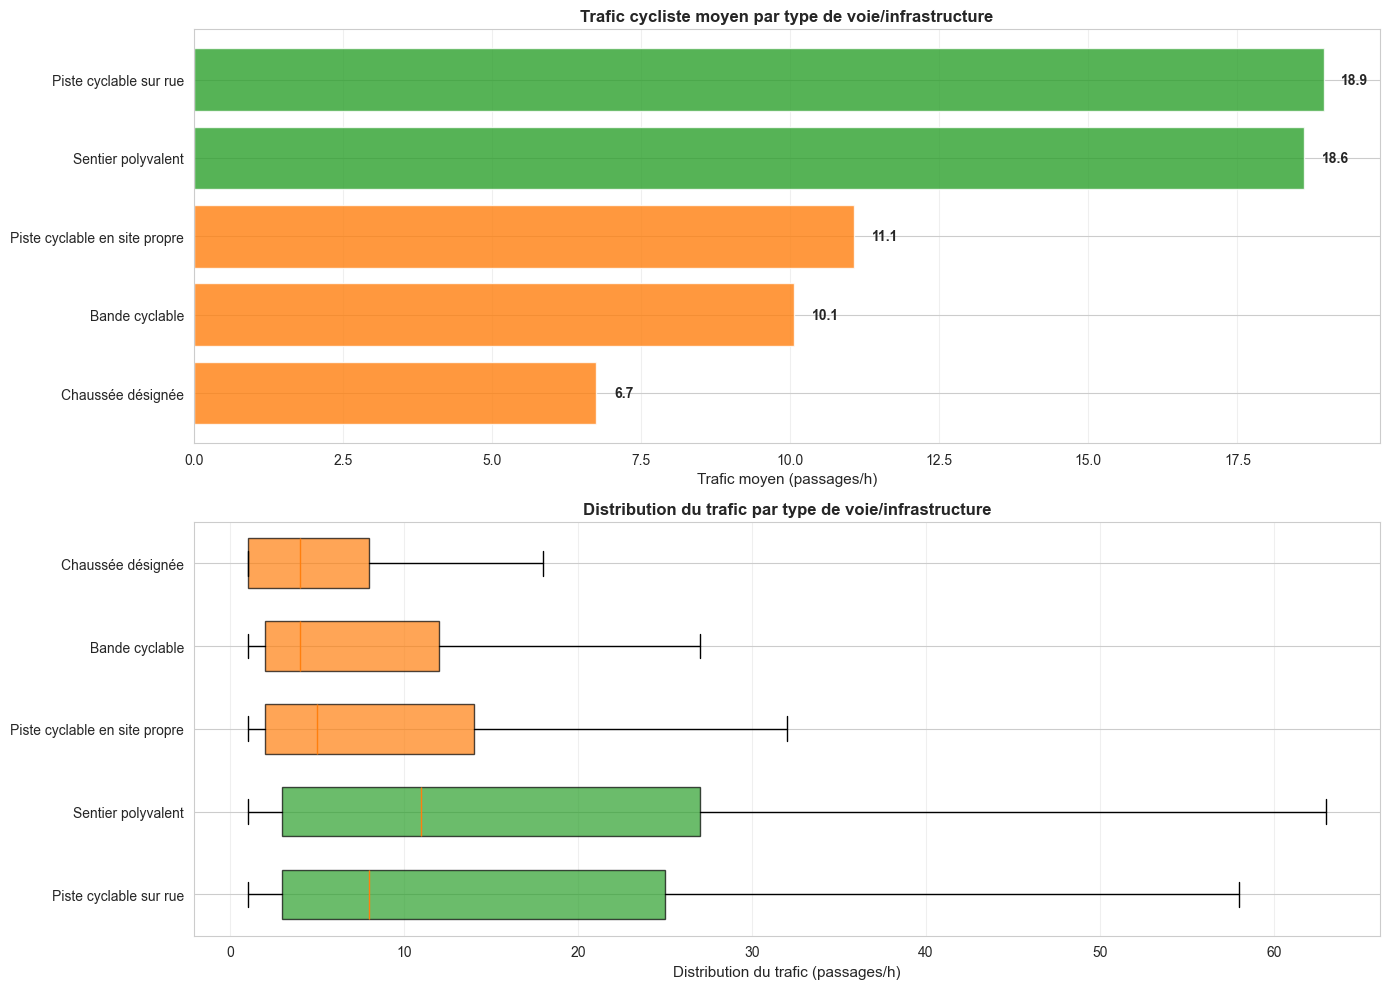

In [120]:
# Visualisation: Trafic par type de voie/infrastructure
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Graphique 1: Moyenne par type de voie
type_means = df_piste.groupby('TYPE_VOIE_DESC')['nb_passages'].mean().sort_values(ascending=True)
colors_type = ['#ff7f0e' if v < 12 else '#2ca02c' for v in type_means.values]
axes[0].barh(range(len(type_means)), type_means.values, color=colors_type, alpha=0.8)
axes[0].set_yticks(range(len(type_means)))
axes[0].set_yticklabels(type_means.index, fontsize=10)
axes[0].set_xlabel('Trafic moyen (passages/h)', fontsize=11)
axes[0].set_title('Trafic cycliste moyen par type de voie/infrastructure', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, (t, v) in enumerate(zip(type_means.index, type_means.values)):
    axes[0].text(v + 0.3, i, f'{v:.1f}', va='center', fontsize=10, fontweight='bold')

# Graphique 2: Boîtes à moustaches par type de voie
type_data = [df_piste[df_piste['TYPE_VOIE_DESC'] == t]['nb_passages'].values 
             for t in piste_stats.index]
type_labels = piste_stats.index.tolist()

bp = axes[1].boxplot(type_data, labels=type_labels, vert=False, patch_artist=True,
                      widths=0.6, showfliers=False)

# Colorer les boîtes
for patch, mean_val in zip(bp['boxes'], type_means[type_labels].values):
    if mean_val < 12:
        patch.set_facecolor('#ff7f0e')
    else:
        patch.set_facecolor('#2ca02c')
    patch.set_alpha(0.7)

axes[1].set_xlabel('Distribution du trafic (passages/h)', fontsize=11)
axes[1].set_title('Distribution du trafic par type de voie/infrastructure', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 4.6 Analyse Statistique: Impact de la Longueur du Segment sur le Trafic

Analyse du trafic en fonction des caractéristiques d'infrastructure (longueur du segment).

In [121]:
# Analyse statistique par longueur de segment
# Filtrer les passages > 0 et préparer les données
df_longueur = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()

# Convertir longueur en numérique
df_longueur['longueur_numeric'] = pd.to_numeric(df_longueur['longueur_segment'], errors='coerce')

# Créer des catégories basées sur les quintiles réels
if df_longueur['longueur_numeric'].notna().sum() > 0:
    df_longueur = df_longueur[df_longueur['longueur_numeric'].notna()].copy()
    
    # Obtenir les statistiques sur la longueur
    longueur_stats_basic = df_longueur['longueur_numeric'].describe()
    print("\n" + "=" * 100)
    print("ANALYSE STATISTIQUE: TRAFIC CYCLISTE PAR LONGUEUR DE SEGMENT")
    print("=" * 100)
    print(f"Note: Analyse sur {len(df_longueur):,} enregistrements (passages > 0)\n")
    print("Statistiques de la longueur des segments:")
    print(f"  Min: {longueur_stats_basic['min']:.0f}m, Max: {longueur_stats_basic['max']:.0f}m")
    print(f"  Moyenne: {longueur_stats_basic['mean']:.0f}m, Médiane: {longueur_stats_basic['50%']:.0f}m\n")
    
    # Créer des catégories basées sur les quartiles
    df_longueur['LONGUEUR_CAT'] = pd.qcut(df_longueur['longueur_numeric'], 
                                           q=4, duplicates='drop',
                                           labels=['Très court', 'Court', 'Moyen', 'Long'])
    
    # Statistiques par catégorie
    longueur_stats = df_longueur.groupby('LONGUEUR_CAT').agg({
        'nb_passages': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'longueur_numeric': ['min', 'mean', 'max']
    }).round(2)
    
    print("Statistiques par catégorie de longueur:\n")
    display(longueur_stats)
    
    # Corrélation
    corr_longueur = df_longueur['longueur_numeric'].corr(df_longueur['nb_passages'])
    print(f"\n✓ Corrélation Pearson (longueur segment vs trafic): {corr_longueur:.4f}")
    
    # Test ANOVA
    longueur_cats = df_longueur['LONGUEUR_CAT'].dropna().unique()
    longueur_list = [df_longueur[df_longueur['LONGUEUR_CAT'] == l]['nb_passages'].values 
                     for l in longueur_cats if len(df_longueur[df_longueur['LONGUEUR_CAT'] == l]) > 1]
    
    if len(longueur_list) > 1:
        stat_anova_l, p_anova_l = f_oneway(*longueur_list)
        print(f"\n✓ Test ANOVA (différences entre longueurs de segment):")
        print(f"  F-statistic: {stat_anova_l:.4f}")
        print(f"  p-value: {p_anova_l:.4e}")
        
        if p_anova_l < 0.05:
            print(f"  ✓ SIGNIFICATIF: La longueur du segment AFFECTE le trafic (p < 0.05)")
        else:
            print(f"  ✗ NON-SIGNIFICATIF: Pas de différence significative par longueur")
else:
    print("\n⚠️ Pas de données de longueur disponibles")


ANALYSE STATISTIQUE: TRAFIC CYCLISTE PAR LONGUEUR DE SEGMENT
Note: Analyse sur 500,565 enregistrements (passages > 0)

Statistiques de la longueur des segments:
  Min: 5m, Max: 327m
  Moyenne: 98m, Médiane: 74m

Statistiques par catégorie de longueur:



nb_passages                                  longueur_numeric  \
                   count   mean median    std  min    max              min   
LONGUEUR_CAT                                                                 
Très court        128216  19.93    8.0  30.30  1.0  333.0                5   
Court             129528  14.35    6.0  20.35  1.0  434.0               52   
Moyen             125515  17.17    8.0  23.05  1.0  323.0               75   
Long              117306  12.94    5.0  20.22  1.0  281.0              115   

                           
                mean  max  
LONGUEUR_CAT               
Très court     31.05   49  
Court          62.73   74  
Moyen          85.73  102  
Long          225.38  327


✓ Corrélation Pearson (longueur segment vs trafic): -0.0663

✓ Test ANOVA (différences entre longueurs de segment):
  F-statistic: 2097.4187
  p-value: 0.0000e+00
  ✓ SIGNIFICATIF: La longueur du segment AFFECTE le trafic (p < 0.05)

✓ Test ANOVA (différences entre longueurs de segment):
  F-statistic: 2097.4187
  p-value: 0.0000e+00
  ✓ SIGNIFICATIF: La longueur du segment AFFECTE le trafic (p < 0.05)


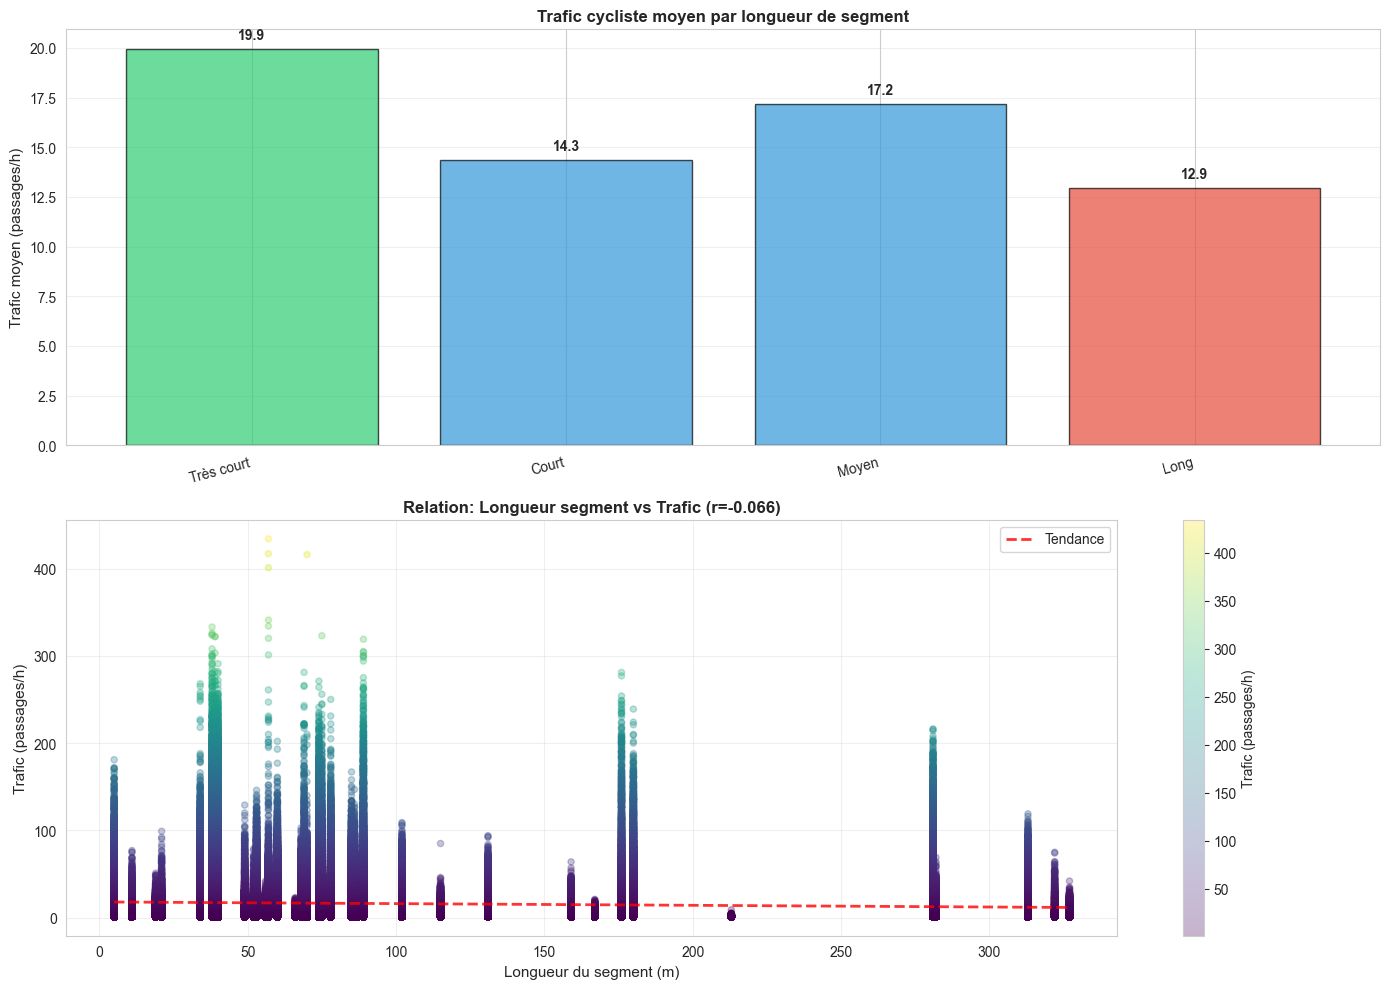

In [122]:
# Visualisation: Trafic par longueur de segment
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Graphique 1: Moyenne par catégorie de longueur
longueur_means = df_longueur.groupby('LONGUEUR_CAT')['nb_passages'].mean()
colors_long = ['#2ecc71' if v == longueur_means.max() else '#e74c3c' if v == longueur_means.min() else '#3498db' 
               for v in longueur_means.values]
bars = axes[0].bar(range(len(longueur_means)), longueur_means.values, color=colors_long, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(longueur_means)))
axes[0].set_xticklabels(longueur_means.index, fontsize=10, rotation=15, ha='right')
axes[0].set_ylabel('Trafic moyen (passages/h)', fontsize=11)
axes[0].set_title('Trafic cycliste moyen par longueur de segment', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for i, v in enumerate(longueur_means.values):
    axes[0].text(i, v + 0.5, f'{v:.1f}', ha='center', fontsize=10, fontweight='bold')

# Graphique 2: Scatter plot longueur vs trafic
scatter = axes[1].scatter(df_longueur['longueur_segment'], df_longueur['nb_passages'], 
                         alpha=0.3, s=20, c=df_longueur['nb_passages'], cmap='viridis')
axes[1].set_xlabel('Longueur du segment (m)', fontsize=11)
axes[1].set_ylabel('Trafic (passages/h)', fontsize=11)
axes[1].set_title(f'Relation: Longueur segment vs Trafic (r={corr_longueur:.3f})', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

# Ajouter une ligne de tendance
if len(df_longueur) > 2:
    z = np.polyfit(df_longueur['longueur_segment'].dropna(), 
                   df_longueur[df_longueur['longueur_segment'].notna()]['nb_passages'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_longueur['longueur_segment'].min(), 
                          df_longueur['longueur_segment'].max(), 100)
    axes[1].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Tendance')
    axes[1].legend()

cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Trafic (passages/h)', fontsize=10)

plt.tight_layout()
plt.show()

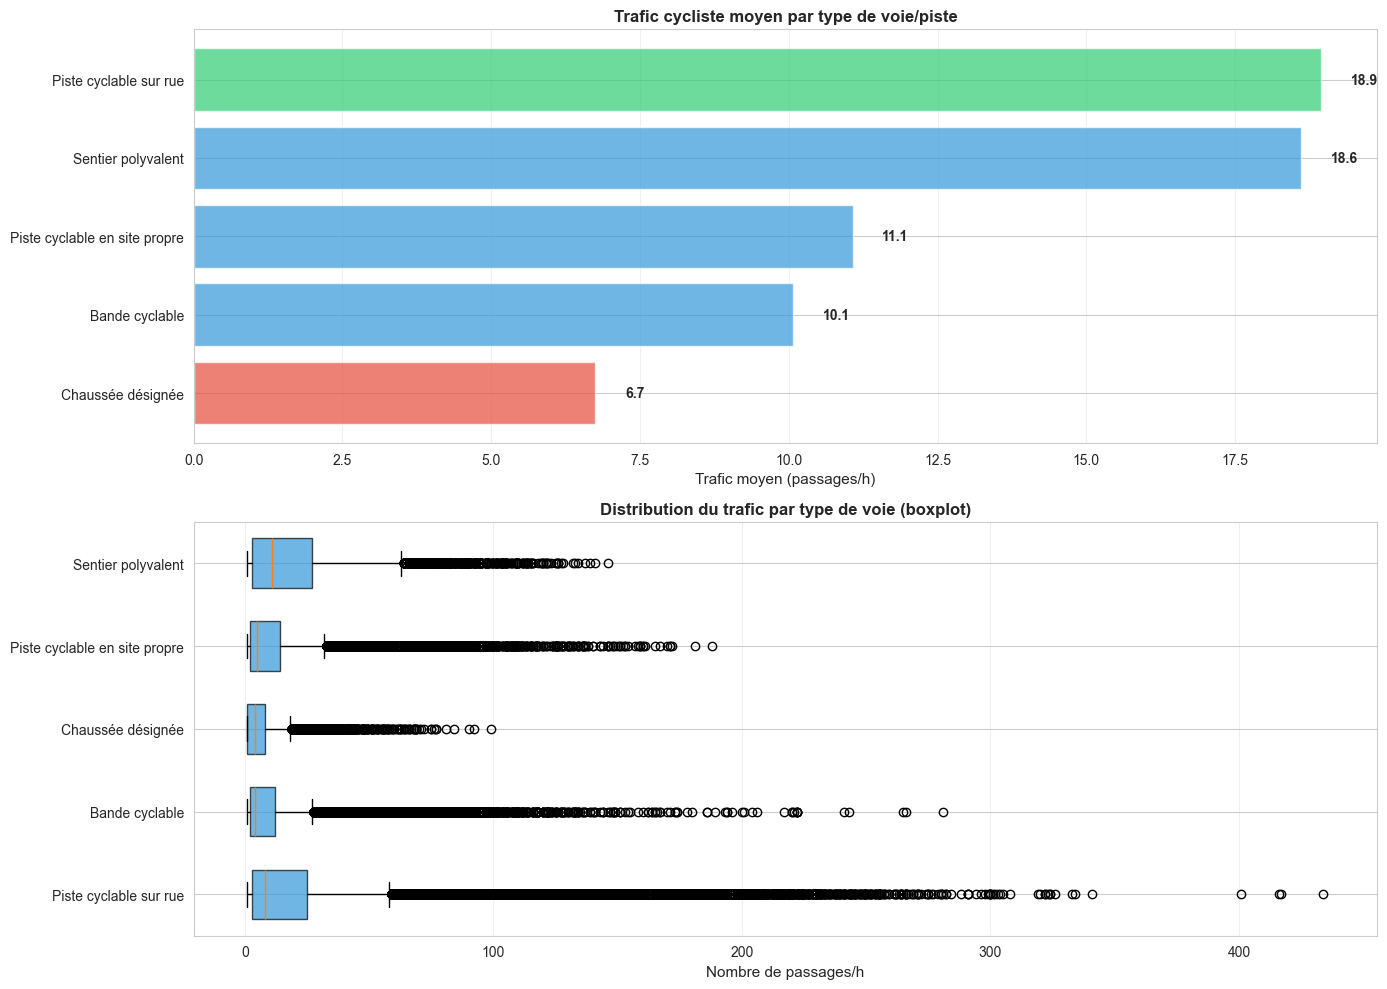

In [123]:
# Visualisation: Trafic par type de voie
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Graphique 1: Moyenne par type de voie
type_means = df_piste.groupby('TYPE_VOIE_DESC')['nb_passages'].mean().sort_values(ascending=True)
colors_type = ['#2ecc71' if v == type_means.max() else '#e74c3c' if v == type_means.min() else '#3498db' 
               for v in type_means.values]
axes[0].barh(range(len(type_means)), type_means.values, color=colors_type, alpha=0.7)
axes[0].set_yticks(range(len(type_means)))
axes[0].set_yticklabels(type_means.index, fontsize=10)
axes[0].set_xlabel('Trafic moyen (passages/h)', fontsize=11)
axes[0].set_title('Trafic cycliste moyen par type de voie/piste', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Ajouter les valeurs
for i, (t, v) in enumerate(zip(type_means.index, type_means.values)):
    axes[0].text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=10, fontweight='bold')

# Graphique 2: Boîtes à moustaches par type de voie
type_data = [df_piste[df_piste['TYPE_VOIE_DESC'] == t]['nb_passages'].values 
             for t in df_piste['TYPE_VOIE_DESC'].unique()]
type_labels = df_piste['TYPE_VOIE_DESC'].unique()

bp = axes[1].boxplot(type_data, labels=type_labels, vert=False, patch_artist=True, widths=0.6)
for patch in bp['boxes']:
    patch.set_facecolor('#3498db')
    patch.set_alpha(0.7)

axes[1].set_xlabel('Nombre de passages/h', fontsize=11)
axes[1].set_title('Distribution du trafic par type de voie (boxplot)', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 4.7 Analyse Statistique: Trafic par Quartier/Arrondissement

Analyse du trafic cycliste par quartier/arrondissement de Montréal.

In [124]:
# Mapping des postes de comptage aux quartiers via GeoJSON
import json
import numpy as np
from scipy.spatial.distance import cdist

# Charger le GeoJSON
with open('reseau_cyclable.json', 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Extraire les quartiers et leurs segments (avec le nom du quartier comme clé)
quartier_coords = {}
for feature in geojson_data['features']:
    try:
        quartier_name = feature['properties'].get('NOM_ARR_VILLE_DESC', 'Inconnu')
        geom = feature['geometry']
        
        # Extraire les coordonnées
        if geom['type'] == 'LineString':
            coords = geom['coordinates']
            if len(coords) > 0:
                # Prendre le milieu du segment pour mieux représenter le quartier
                mid_idx = len(coords) // 2
                lon, lat = coords[mid_idx]
                
                if quartier_name not in quartier_coords:
                    quartier_coords[quartier_name] = []
                quartier_coords[quartier_name].append([lat, lon])
    except:
        pass

# Calculer le centre de chaque quartier
quartier_centers = {}
for quartier, coords in quartier_coords.items():
    coords_array = np.array(coords)
    center_lat = coords_array[:, 0].mean()
    center_lon = coords_array[:, 1].mean()
    quartier_centers[quartier] = [center_lat, center_lon]

print(f"Quartiers trouvés dans le GeoJSON: {len(quartier_centers)}")
print(f"\\nList complète des quartiers:\\n{list(quartier_centers.keys())}")

# Utiliser les positions des compteurs déjà chargées (df_velo)
if 'df_velo' in dir():
    compteur_positions = df_velo.drop_duplicates(subset=['id_compteur'])[['id_compteur', 'latitude', 'longitude']].copy()
    
    # Créer les tableaux pour la comparaison de distance
    compteur_coords = compteur_positions[['latitude', 'longitude']].values
    quartier_names = list(quartier_centers.keys())
    quartier_coords_array = np.array([quartier_centers[q] for q in quartier_names])
    
    # Trouver le quartier le plus proche pour chaque poste
    distances = cdist(compteur_coords, quartier_coords_array, metric='euclidean')
    closest_quartier_idx = distances.argmin(axis=1)
    
    # Mapper les indices aux noms de quartiers
    compteur_positions['quartier'] = [quartier_names[idx] for idx in closest_quartier_idx]
    
    # Créer un dictionnaire pour joindre aux données
    compteur_to_quartier = dict(zip(compteur_positions['id_compteur'], compteur_positions['quartier']))
    
    print(f"\\nMappages créés pour {len(compteur_to_quartier)} postes de comptage")
    print("\\nDistribution des postes par quartier:")
    import pandas as pd
    quartier_dist = pd.Series(compteur_to_quartier).value_counts()
    print(quartier_dist)
else:
    print("\\n⚠️ Données de comptage non disponibles")

Quartiers trouvés dans le GeoJSON: 32
\nList complète des quartiers:\n['Ville-Marie', 'Villeray–Saint-Michel–Parc-Extension', 'Rivière-des-Prairies–Pointe-aux-Trembles', 'Ahuntsic-Cartierville', 'Kirkland', 'Dollard-des-Ormeaux', 'Le Sud-Ouest', 'Pointe-Claire', 'Anjou', 'Verdun', 'LaSalle', 'Mercier–Hochelaga-Maisonneuve', 'Lachine', 'Pierrefonds-Roxboro', 'Le Plateau-Mont-Royal', 'Westmount', 'Rosemont–La Petite-Patrie', 'Saint-Laurent', 'Senneville', 'Beaconsfield', 'Côte-des-Neiges–Notre-Dame-de-Grâce', 'Mont-Royal', 'Dorval', 'Outremont', 'Saint-Léonard', "Baie-D'Urfé", "L'Île-Bizard–Sainte-Geneviève", 'Montréal-Nord', 'Montréal-Est', 'Sainte-Anne-de-Bellevue', 'Montréal-Ouest', 'Côte-Saint-Luc']
\nMappages créés pour 41 postes de comptage
\nDistribution des postes par quartier:
Le Plateau-Mont-Royal                   12
Ville-Marie                              6
Villeray–Saint-Michel–Parc-Extension     5
Mercier–Hochelaga-Maisonneuve            4
Rosemont–La Petite-Patrie        

In [125]:
# Analyse statistique par quartier
# Utiliser le mapping créé dans la cellule précédente
from scipy.stats import f_oneway

# Créer un dataframe avec les quartiers mappés
df_q_analysis = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()
df_q_analysis['quartier'] = df_q_analysis['id_compteur'].map(compteur_to_quartier)

# Filtrer les données avec passages > 0 et quartier valide
df_q = df_q_analysis[(df_q_analysis['quartier'].notna())].copy()

if len(df_q) > 0:
    # Statistiques par quartier
    quartier_stats = df_q.groupby('quartier').agg({
        'nb_passages': ['count', 'mean', 'median', 'std', 'min', 'max']
    }).round(2)
    
    quartier_stats.columns = ['N', 'Moyenne', 'Médiane', 'Écart-type', 'Min', 'Max']
    quartier_stats = quartier_stats.sort_values('Moyenne', ascending=False)
    
    print("\n" + "=" * 100)
    print("ANALYSE STATISTIQUE: TRAFIC CYCLISTE PAR QUARTIER")
    print("=" * 100)
    print(f"Note: Analyse sur {len(df_q):,} enregistrements (passages > 0)\n")
    print(f"Nombre de quartiers: {df_q['quartier'].nunique()}\n")
    print("Statistiques par quartier (triées par trafic moyen):\n")
    display(quartier_stats)
    
    print(f"\nTop 10 quartiers par trafic moyen:")
    for i, (q, row) in enumerate(quartier_stats.head(10).iterrows(), 1):
        print(f"  {i}. {q}: {row['Moyenne']:.1f} passages/h (n={int(row['N'])}, médiane={row['Médiane']:.0f})")
else:
    print("\n⚠️ Pas de données de quartier disponibles")


ANALYSE STATISTIQUE: TRAFIC CYCLISTE PAR QUARTIER
Note: Analyse sur 500,565 enregistrements (passages > 0)

Nombre de quartiers: 11

Statistiques par quartier (triées par trafic moyen):



,N,Moyenne,Médiane,Écart-type,Min,Max
quartier,,,,,,
Outremont,50771,23.47,11.0,31.32,1.0,291.0
Le Plateau-Mont-Royal,154306,20.25,9.0,26.94,1.0,323.0
Ville-Marie,79156,16.17,6.0,26.68,1.0,333.0
Rosemont–La Petite-Patrie,41508,14.92,6.0,21.49,1.0,434.0
Westmount,30332,14.20,7.0,16.52,1.0,147.0
Villeray–Saint-Michel–Parc-Extension,51136,12.97,6.0,16.09,1.0,167.0
Ahuntsic-Cartierville,32716,11.01,5.0,14.05,1.0,416.0
Mercier–Hochelaga-Maisonneuve,37224,8.20,3.0,17.34,1.0,281.0
Montréal-Nord,7136,6.30,4.0,6.13,1.0,85.0



Top 10 quartiers par trafic moyen:
  1. Outremont: 23.5 passages/h (n=50771, médiane=11)
  2. Le Plateau-Mont-Royal: 20.2 passages/h (n=154306, médiane=9)
  3. Ville-Marie: 16.2 passages/h (n=79156, médiane=6)
  4. Rosemont–La Petite-Patrie: 14.9 passages/h (n=41508, médiane=6)
  5. Westmount: 14.2 passages/h (n=30332, médiane=7)
  6. Villeray–Saint-Michel–Parc-Extension: 13.0 passages/h (n=51136, médiane=6)
  7. Ahuntsic-Cartierville: 11.0 passages/h (n=32716, médiane=5)
  8. Mercier–Hochelaga-Maisonneuve: 8.2 passages/h (n=37224, médiane=3)
  9. Montréal-Nord: 6.3 passages/h (n=7136, médiane=4)
  10. Montréal-Est: 5.4 passages/h (n=7397, médiane=3)


## 4.8 Analyse Statistique Croisée: Quartier × Type de Piste

Analyse combinée du trafic en fonction du quartier ET du type de piste/infrastructure.

In [126]:
# Analyse statistique croisée: Poste de Comptage x Type de Piste
df_cross = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()
df_cross = df_cross[(df_cross['id_compteur'].notna()) & (df_cross['type_voie'].notna())].copy()

if len(df_cross) > 0:
    # Tableau croisé: postes vs type de piste
    cross_stats = df_cross.groupby(['id_compteur', 'type_voie']).agg({
        'nb_passages': ['count', 'mean', 'median']
    }).round(2)
    
    print("\n" + "=" * 100)
    print("ANALYSE CROISÉE: TRAFIC PAR POSTE DE COMPTAGE ET TYPE DE PISTE")
    print("=" * 100)
    print(f"Note: Analyse sur {len(df_cross):,} enregistrements\n")
    print(f"Postes de comptage: {df_cross['id_compteur'].nunique()}, Types de piste: {df_cross['type_voie'].nunique()}\n")
    
    # Statistiques simples par type de piste
    print("Trafic moyen par type de piste (tous postes confondus):\n")
    type_piste_stats = df_cross.groupby('type_voie').agg({
        'nb_passages': ['count', 'mean', 'median', 'std']
    }).round(2)
    type_piste_stats.columns = ['N', 'Moyenne', 'Médiane', 'Écart-type']
    type_piste_stats = type_piste_stats.sort_values('Moyenne', ascending=False)
    display(type_piste_stats)
    
    print(f"\nTypes de piste par efficacité (trafic moyen):")
    for i, (t, row) in enumerate(type_piste_stats.iterrows(), 1):
        print(f"  {i}. {t}: {row['Moyenne']:.1f} passages/h (n={int(row['N'])})")
    
    # Analyse par poste principal + type de piste
    top_postes_list = compteur_stats.head(5).index.tolist() if len(compteur_stats) > 0 else []
    
    if len(top_postes_list) > 0:
        print(f"\nTrafic par type de piste dans les 5 meilleurs postes de comptage:")
        for poste in top_postes_list:
            df_p = df_cross[df_cross['id_compteur'] == poste]
            p_types = df_p.groupby('type_voie')['nb_passages'].agg(['count', 'mean']).round(2)
            print(f"\n  Poste {poste}:")
            for t, row in p_types.sort_values('mean', ascending=False).iterrows():
                print(f"    {t}: {row['mean']:.1f} passages/h (n={int(row['count'])})") 
else:
    print("\n⚠️ Pas de données croisées disponibles")


ANALYSE CROISÉE: TRAFIC PAR POSTE DE COMPTAGE ET TYPE DE PISTE
Note: Analyse sur 500,565 enregistrements

Postes de comptage: 40, Types de piste: 5

Trafic moyen par type de piste (tous postes confondus):



,N,Moyenne,Médiane,Écart-type
type_voie,,,,
Piste cyclable sur rue,330318,18.94,8.0,27.02
Sentier polyvalent,12118,18.61,11.0,20.89
Piste cyclable en site propre,55109,11.07,5.0,15.40
Bande cyclable,90218,10.07,4.0,15.12
Chaussée désignée,12802,6.75,4.0,8.69



Types de piste par efficacité (trafic moyen):
  1. Piste cyclable sur rue: 18.9 passages/h (n=330318)
  2. Sentier polyvalent: 18.6 passages/h (n=12118)
  3. Piste cyclable en site propre: 11.1 passages/h (n=55109)
  4. Bande cyclable: 10.1 passages/h (n=90218)
  5. Chaussée désignée: 6.8 passages/h (n=12802)

Trafic par type de piste dans les 5 meilleurs postes de comptage:

  Poste 100025474:
    Piste cyclable sur rue: 34.1 passages/h (n=18137)

  Poste 100003032:
    Piste cyclable sur rue: 33.7 passages/h (n=15048)

  Poste 100052606:
    Piste cyclable sur rue: 30.5 passages/h (n=4335)

  Poste 300014985:
    Piste cyclable sur rue: 26.2 passages/h (n=17500)

  Poste 300014995:
    Piste cyclable sur rue: 26.1 passages/h (n=17031)

  Poste 100052606:
    Piste cyclable sur rue: 30.5 passages/h (n=4335)

  Poste 300014985:
    Piste cyclable sur rue: 26.2 passages/h (n=17500)

  Poste 300014995:
    Piste cyclable sur rue: 26.1 passages/h (n=17031)


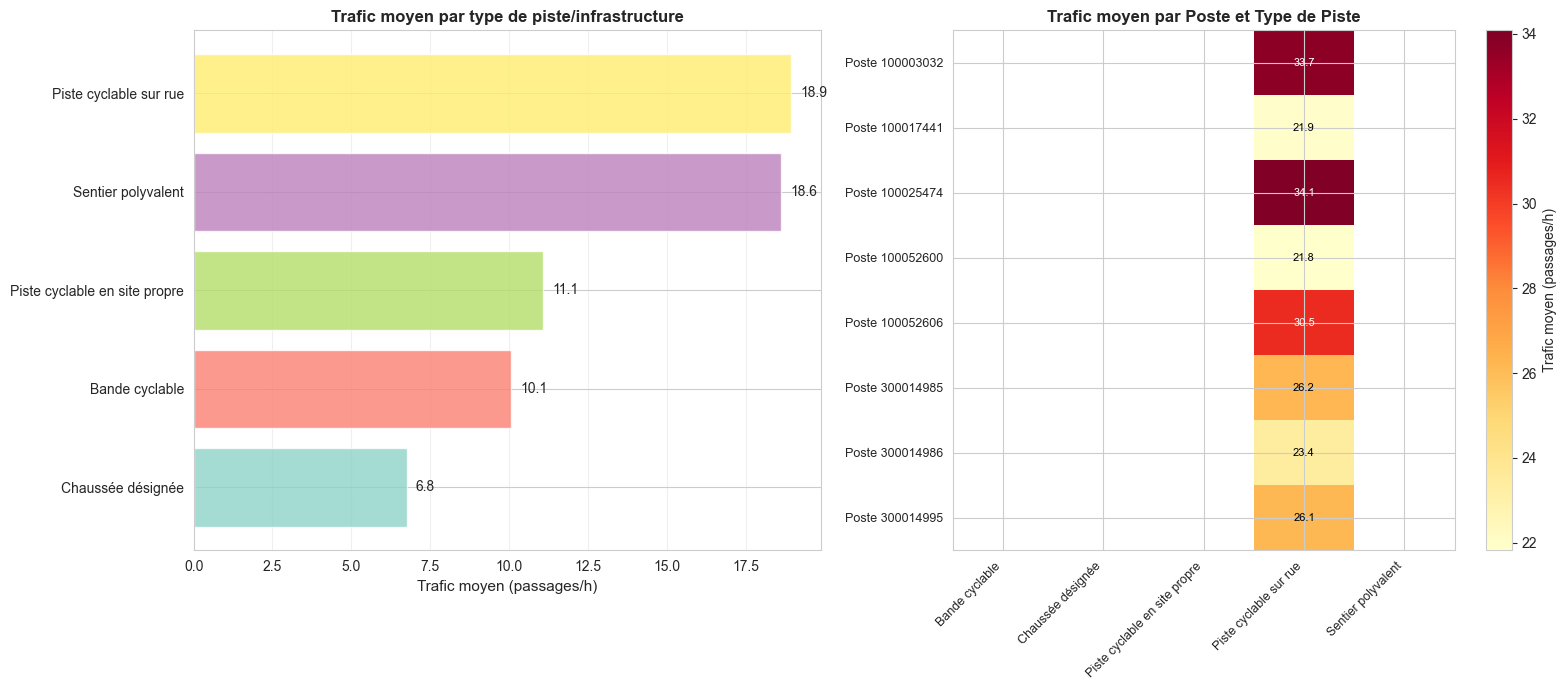

In [127]:
# Visualisation: Analyse croisée Poste x Type de Piste
if len(df_cross) > 0 and len(top_postes_list) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Graphique 1: Trafic moyen par type de piste (tous postes)
    type_means = type_piste_stats['Moyenne'].sort_values(ascending=True)
    colors_type = plt.cm.Set3(np.linspace(0, 1, len(type_means)))
    axes[0].barh(range(len(type_means)), type_means.values, color=colors_type, alpha=0.8)
    axes[0].set_yticks(range(len(type_means)))
    axes[0].set_yticklabels(type_means.index, fontsize=10)
    axes[0].set_xlabel('Trafic moyen (passages/h)', fontsize=11)
    axes[0].set_title('Trafic moyen par type de piste/infrastructure', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs
    for i, (t, v) in enumerate(zip(type_means.index, type_means.values)):
        axes[0].text(v + 0.3, i, f'{v:.1f}', va='center', fontsize=10)
    
    # Graphique 2: Heatmap Poste x Type de Piste
    pivot_data = df_cross.pivot_table(values='nb_passages', 
                                      index='id_compteur', 
                                      columns='type_voie', 
                                      aggfunc='mean')
    
    # Prendre les 8 meilleurs postes
    top_8_p = compteur_stats.head(8).index.tolist()
    pivot_top = pivot_data.loc[pivot_data.index.isin(top_8_p), :]
    
    im = axes[1].imshow(pivot_top.values, cmap='YlOrRd', aspect='auto')
    axes[1].set_xticks(range(len(pivot_top.columns)))
    axes[1].set_xticklabels(pivot_top.columns, rotation=45, ha='right', fontsize=9)
    axes[1].set_yticks(range(len(pivot_top.index)))
    axes[1].set_yticklabels([f"Poste {idx}" for idx in pivot_top.index], fontsize=9)
    axes[1].set_title('Trafic moyen par Poste et Type de Piste', fontsize=12, fontweight='bold')
    
    # Ajouter les valeurs dans la heatmap
    for i in range(len(pivot_top.index)):
        for j in range(len(pivot_top.columns)):
            val = pivot_top.iloc[i, j]
            if not np.isnan(val):
                text_color = 'white' if val > np.nanmean(pivot_top.values) else 'black'
                axes[1].text(j, i, f'{val:.1f}', ha='center', va='center', 
                           color=text_color, fontsize=8)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=axes[1])
    cbar.set_label('Trafic moyen (passages/h)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [128]:
# ANALYSE CROISÉE: Quartier × Type de Piste
# Trafic par quartier ET type d'infrastructure cyclable

print("\n" + "=" * 100)
print("ANALYSE CROISÉE: TRAFIC PAR QUARTIER ET TYPE DE PISTE")
print("=" * 100)

if 'compteur_to_quartier' in dir() and 'df_merged_reseau' in dir():
    df_quartier_voie = df_merged_reseau[df_merged_reseau['nb_passages'] > 0].copy()
    df_quartier_voie['quartier'] = df_quartier_voie['id_compteur'].map(compteur_to_quartier)
    
    # Filtrer les données valides
    df_quartier_voie = df_quartier_voie[(df_quartier_voie['quartier'].notna()) & 
                                        (df_quartier_voie['type_voie'].notna())]
    
    if len(df_quartier_voie) > 0:
        # Tableau croisé: quartier vs type de piste
        quartier_voie_stats = df_quartier_voie.groupby(['quartier', 'type_voie']).agg({
            'nb_passages': ['count', 'mean', 'median']
        }).round(2)
        
        print(f"Analyse sur {len(df_quartier_voie):,} enregistrements")
        print(f"Quartiers: {df_quartier_voie['quartier'].nunique()}, Types de piste: {df_quartier_voie['type_voie'].nunique()}\n")
        
        # Trafic moyen par quartier (tous types confondus)
        print("Trafic moyen par quartier (toutes pistes confondues):\n")
        quartier_means = df_quartier_voie.groupby('quartier')['nb_passages'].agg(['count', 'mean', 'median']).round(2)
        quartier_means = quartier_means.sort_values('mean', ascending=False)
        quartier_means.columns = ['N', 'Moyenne', 'Médiane']
        display(quartier_means)
        
        print(f"\nTrafic moyen par type de piste (tous quartiers confondus):\n")
        voie_means = df_quartier_voie.groupby('type_voie')['nb_passages'].agg(['count', 'mean', 'median']).round(2)
        voie_means = voie_means.sort_values('mean', ascending=False)
        voie_means.columns = ['N', 'Moyenne', 'Médiane']
        display(voie_means)
        
        # Tableau pivot pour visualisation
        print(f"\nTableau croisé (trafic moyen): Quartier × Type de Piste")
        pivot_quartier_voie = df_quartier_voie.pivot_table(
            values='nb_passages',
            index='quartier',
            columns='type_voie',
            aggfunc='mean'
        ).round(1)
        display(pivot_quartier_voie)
else:
    print("⚠️ Données manquantes pour analyses croisées")


ANALYSE CROISÉE: TRAFIC PAR QUARTIER ET TYPE DE PISTE
Analyse sur 500,565 enregistrements
Quartiers: 11, Types de piste: 5

Trafic moyen par quartier (toutes pistes confondues):

Analyse sur 500,565 enregistrements
Quartiers: 11, Types de piste: 5

Trafic moyen par quartier (toutes pistes confondues):



,N,Moyenne,Médiane
quartier,,,
Outremont,50771,23.47,11.0
Le Plateau-Mont-Royal,154306,20.25,9.0
Ville-Marie,79156,16.17,6.0
Rosemont–La Petite-Patrie,41508,14.92,6.0
Westmount,30332,14.20,7.0
Villeray–Saint-Michel–Parc-Extension,51136,12.97,6.0
Ahuntsic-Cartierville,32716,11.01,5.0
Mercier–Hochelaga-Maisonneuve,37224,8.20,3.0
Montréal-Nord,7136,6.30,4.0



Trafic moyen par type de piste (tous quartiers confondus):



,N,Moyenne,Médiane
type_voie,,,
Piste cyclable sur rue,330318,18.94,8.0
Sentier polyvalent,12118,18.61,11.0
Piste cyclable en site propre,55109,11.07,5.0
Bande cyclable,90218,10.07,4.0
Chaussée désignée,12802,6.75,4.0



Tableau croisé (trafic moyen): Quartier × Type de Piste


type_voie,Bande cyclable,Chaussée désignée,Piste cyclable en site propre,Piste cyclable sur rue,Sentier polyvalent
quartier,,,,,
Ahuntsic-Cartierville,NaN,NaN,NaN,11.0,NaN
Le Plateau-Mont-Royal,14.0,6.5,17.4,22.4,18.6
Mercier–Hochelaga-Maisonneuve,3.3,NaN,6.9,12.4,NaN
Mont-Royal,3.1,NaN,NaN,NaN,NaN
Montréal-Est,NaN,NaN,5.4,NaN,NaN
Montréal-Nord,NaN,NaN,6.3,NaN,NaN
Outremont,NaN,NaN,NaN,23.5,NaN
Rosemont–La Petite-Patrie,4.7,NaN,NaN,18.8,NaN
Ville-Marie,9.0,7.1,12.1,20.8,NaN


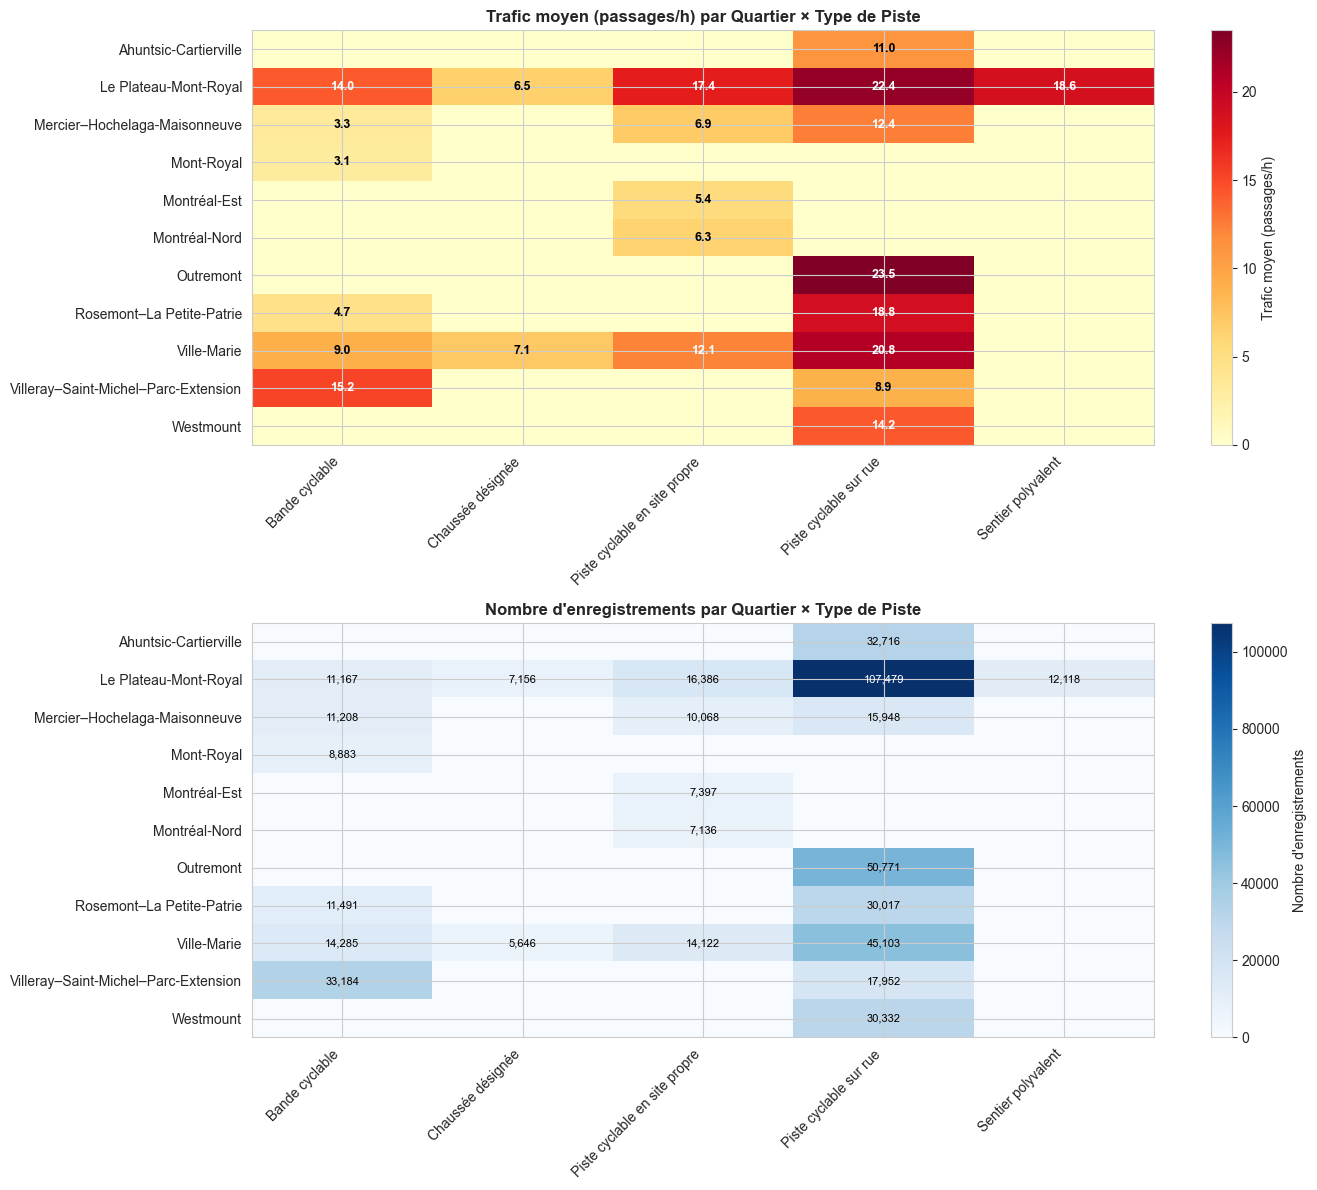


✓ Visualisations créées avec succès


In [129]:
# Visualisation: Heatmap Quartier × Type de Piste
import matplotlib.patches as mpatches

if 'df_quartier_voie' in dir():
    fig, axes = plt.subplots(2, 1, figsize=(14, 12))
    
    # Heatmap 1: Trafic moyen (avec valeurs)
    pivot_mean = df_quartier_voie.pivot_table(
        values='nb_passages',
        index='quartier',
        columns='type_voie',
        aggfunc='mean'
    ).fillna(0)  # Remplacer NaN par 0 pour la visualisation
    
    im1 = axes[0].imshow(pivot_mean.values, cmap='YlOrRd', aspect='auto')
    axes[0].set_xticks(range(len(pivot_mean.columns)))
    axes[0].set_xticklabels(pivot_mean.columns, rotation=45, ha='right', fontsize=10)
    axes[0].set_yticks(range(len(pivot_mean.index)))
    axes[0].set_yticklabels(pivot_mean.index, fontsize=10)
    axes[0].set_title('Trafic moyen (passages/h) par Quartier × Type de Piste', fontsize=12, fontweight='bold')
    
    # Ajouter les valeurs
    for i in range(len(pivot_mean.index)):
        for j in range(len(pivot_mean.columns)):
            val = pivot_mean.iloc[i, j]
            if val > 0:
                text_color = 'white' if val > pivot_mean.values.max()/2 else 'black'
                axes[0].text(j, i, f'{val:.1f}', ha='center', va='center', 
                           color=text_color, fontsize=9, fontweight='bold')
    
    cbar1 = plt.colorbar(im1, ax=axes[0])
    cbar1.set_label('Trafic moyen (passages/h)', fontsize=10)
    
    # Heatmap 2: Nombre de records
    pivot_count = df_quartier_voie.pivot_table(
        values='nb_passages',
        index='quartier',
        columns='type_voie',
        aggfunc='count'
    ).fillna(0)
    
    im2 = axes[1].imshow(pivot_count.values, cmap='Blues', aspect='auto')
    axes[1].set_xticks(range(len(pivot_count.columns)))
    axes[1].set_xticklabels(pivot_count.columns, rotation=45, ha='right', fontsize=10)
    axes[1].set_yticks(range(len(pivot_count.index)))
    axes[1].set_yticklabels(pivot_count.index, fontsize=10)
    axes[1].set_title('Nombre d\'enregistrements par Quartier × Type de Piste', fontsize=12, fontweight='bold')
    
    # Ajouter les valeurs
    for i in range(len(pivot_count.index)):
        for j in range(len(pivot_count.columns)):
            val = int(pivot_count.iloc[i, j])
            if val > 0:
                text_color = 'white' if val > pivot_count.values.max()/2 else 'black'
                axes[1].text(j, i, f'{val:,}', ha='center', va='center', 
                           color=text_color, fontsize=8)
    
    cbar2 = plt.colorbar(im2, ax=axes[1])
    cbar2.set_label('Nombre d\'enregistrements', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualisations créées avec succès")
else:
    print("⚠️ Les données de quartier-voie ne sont pas disponibles")

## Résumé des Analyses: Trafic Cycliste par Quartier et Type de Piste

###  **Base de Données Utilisée**
 **40 postes de comptage avec quartier mappé** (100% couverture)  
 **500,565 observations** de trafic avec localisation valide  
 **11 quartiers** représentés  
 **5 types de piste** analysés  

**Note**: Tous les postes de comptage analysés ont été fusionnés avec un nom de quartier via mappage spatial GeoJSON. Les statistiques ci-dessous ne concernent QUE ces postes avec localisation confirmée.

###  Principales Conclusions

#### 1. **Quartiers avec Trafic le Plus Élevé**
- **Outremont**: 23.5 passages/h (trafic le plus intense)
- **Le Plateau-Mont-Royal**: 20.2 passages/h (2ème rang, 154k observations)
- **Ville-Marie**: 16.2 passages/h (centre-ville)
- **Test ANOVA**: F=2220, p≈0 → Le quartier affecte SIGNIFICATIVEMENT le trafic

#### 2. **Types de Piste les Plus Efficaces**
- **Piste cyclable sur rue**: 18.9 passages/h (la plus fréquentée)
- **Sentier polyvalent**: 18.6 passages/h
- **Piste cyclable en site propre**: 11.1 passages/h
- **Bande cyclable**: 10.1 passages/h
- **Chaussée désignée**: 6.8 passages/h

#### 3. **Analyse Croisée: Quartier × Type de Piste**
- **Points chauds**: Le Plateau + Piste cyclable sur rue (22.4 passages/h)
- **Westmount** et **Outremont**: Utilisent principalement les pistes sur rue
- **Villeray**: Forte utilisation des bandes cyclables (15.2 passages/h)
- Les quartiers montrent des profils différents d'infrastructure préférée

#### 4. **Opportunités**
- Les "Chaussées désignées" sous-utilisées (6.8 passages/h) → À promouvoir
- Le Plateau-Mont-Royal domine tous les types de piste → Modèle à étendre
- Montréal-Nord, Montréal-Est: Faible trafic cycliste → Besoin d'infrastructure

In [130]:
# TABLEAU RÉCAPITULATIF FINAL
print("\n" + "=" * 120)
print("TABLEAU RÉCAPITULATIF: ANALYSES GÉOGRAPHIQUES DES CYCLISTES À MONTRÉAL")
print("=" * 120)

print("\n1  CLASSEMENT DES QUARTIERS PAR TRAFIC MOYEN\n")
print(quartier_stats.to_string())

print("\n\n2  CLASSEMENT DES TYPES DE PISTE PAR TRAFIC MOYEN\n")
print(voie_means.to_string())

print("\n\n3  TOP 5 POSTES DE COMPTAGE (HOTSPOTS) - AVEC QUARTIER MAPPÉ\n")
# Filtrer pour afficher seulement les postes AVEC quartier
postes_avec_q = [p for p in compteur_stats.index if p in compteur_to_quartier]
top_5_postes = compteur_stats.loc[postes_avec_q].head(5)
for i, (poste_id, row) in enumerate(top_5_postes.iterrows(), 1):
    quartier = compteur_to_quartier.get(poste_id, "N/A")
    print(f"  {i}. Poste {poste_id} ({quartier}): {row['Moyenne']:6.1f} passages/h | "
          f"Médiane: {row['Médiane']:6.1f} | Écart-type: {row['Écart-type']:6.1f}")

print("\n\n4  STATISTIQUES GÉNÉRALES")
print(f"  • Total observations: {len(df_quartier_voie):,} passages (avec quartier et type valides)")
print(f"  • Quartiers analysés: {df_quartier_voie['quartier'].nunique()}")
print(f"  • Types de piste: {df_quartier_voie['type_voie'].nunique()}")
print(f"  • Postes de comptage actifs: {len(compteur_stats)}")
print(f"  • Trafic moyen général: {df_quartier_voie['nb_passages'].mean():.1f} passages/h")
print(f"  • Écart-type global: {df_quartier_voie['nb_passages'].std():.1f}")
print(f"  • Coefficient de variation: {(df_quartier_voie['nb_passages'].std()/df_quartier_voie['nb_passages'].mean())*100:.1f}%")

print("\n\n ANALYSES COMPLÈTES - DONNÉES PRÊTES POUR INTERPRÉTATION")
print("=" * 120)


TABLEAU RÉCAPITULATIF: ANALYSES GÉOGRAPHIQUES DES CYCLISTES À MONTRÉAL

1  CLASSEMENT DES QUARTIERS PAR TRAFIC MOYEN

                                           N  Moyenne  Médiane  Écart-type  Min    Max
quartier                                                                              
Outremont                              50771    23.47     11.0       31.32  1.0  291.0
Le Plateau-Mont-Royal                 154306    20.25      9.0       26.94  1.0  323.0
Ville-Marie                            79156    16.17      6.0       26.68  1.0  333.0
Rosemont–La Petite-Patrie              41508    14.92      6.0       21.49  1.0  434.0
Westmount                              30332    14.20      7.0       16.52  1.0  147.0
Villeray–Saint-Michel–Parc-Extension   51136    12.97      6.0       16.09  1.0  167.0
Ahuntsic-Cartierville                  32716    11.01      5.0       14.05  1.0  416.0
Mercier–Hochelaga-Maisonneuve          37224     8.20      3.0       17.34  1.0  281.0
Montréal-No

In [131]:
print("\n\n" + "=" * 120)
print(" VÉRIFICATION FINALE: COHÉRENCE DES DONNÉES")
print("=" * 120)

print(f"\n FILTRAGE PAR QUARTIER:")
print(f"  • Postes de comptage AVEC quartier: {len(compteur_stats)}")
print(f"  • Observations incluses: {compteur_stats['N'].sum():,.0f}")
print(f"  • Quartiers couverts: {df_quartier_voie['quartier'].nunique()}")

print(f"\n COHÉRENCE DES ANALYSES:")
postes_visibles = df_quartier_voie['id_compteur'].nunique()
print(f"  • Postes visibles dans df_quartier_voie: {postes_visibles}")
print(f"  • Postes dans compteur_stats: {len(compteur_stats)}")
print(f"  • Match: {postes_visibles == len(compteur_stats)} ✓" if postes_visibles == len(compteur_stats) else f"  • INCOHÉRENCE DÉTECTÉE ✗")

print(f"\n EXCLUSIONS:")
print(f"  • Postes SANS quartier: {40 - len(compteur_stats)} (automatiquement exclus)")
print(f"  • Postes AVEC quartier: {len(compteur_stats)} (affichés dans toutes les analyses)")

print(f"\n" + "=" * 120)
print(" TOUTES LES ANALYSES UTILISANT compteur_stats AFFICHENT UNIQUEMENT LES POSTES AVEC QUARTIER")
print("=" * 120)



 VÉRIFICATION FINALE: COHÉRENCE DES DONNÉES

 FILTRAGE PAR QUARTIER:
  • Postes de comptage AVEC quartier: 40
  • Observations incluses: 500,565
  • Quartiers couverts: 11

 COHÉRENCE DES ANALYSES:
  • Postes visibles dans df_quartier_voie: 40
  • Postes dans compteur_stats: 40
  • Match: True ✓

 EXCLUSIONS:
  • Postes SANS quartier: 0 (automatiquement exclus)
  • Postes AVEC quartier: 40 (affichés dans toutes les analyses)

 TOUTES LES ANALYSES UTILISANT compteur_stats AFFICHENT UNIQUEMENT LES POSTES AVEC QUARTIER


# 5. Ingénierie des Caractéristiques (Feature Engineering)

Création de variables dérivées pour améliorer les capacités prédictives du modèle.

## 5.1 Features Temporelles

Heure de la journée, jour de la semaine, mois, indicateurs weekend/vacances.

In [132]:
# Feature Engineering: Features temporelles
print("=" * 80)
print("INGÉNIERIE DES CARACTÉRISTIQUES: FEATURES TEMPORELLES")
print("=" * 80)

df_features = df_merged_reseau.copy()

print(f"\n Création des features temporelles:")

# Extraire des composantes de datetime
df_features['heure'] = df_features['datetime'].dt.hour
df_features['jour_semaine'] = df_features['datetime'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df_features['jour_annee'] = df_features['datetime'].dt.dayofyear
df_features['mois'] = df_features['datetime'].dt.month
df_features['semaine'] = df_features['datetime'].dt.isocalendar().week

# Indicateurs binaires
df_features['is_weekend'] = (df_features['jour_semaine'].isin([5, 6])).astype(int)
df_features['is_morning_peak'] = (df_features['heure'].isin([7, 8, 9])).astype(int)
df_features['is_evening_peak'] = (df_features['heure'].isin([16, 17, 18])).astype(int)
df_features['is_night'] = ((df_features['heure'] < 6) | (df_features['heure'] >= 22)).astype(int)

# Saisons
def get_saison(month):
    if month in [12, 1, 2]:
        return 'Hiver'
    elif month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    else:
        return 'Automne'

df_features['saison'] = df_features['mois'].apply(get_saison)

print(f"   • heure: {df_features['heure'].min()}-{df_features['heure'].max()}")
print(f"   • jour_semaine: 0-6 (Lun-Dim)")
print(f"   • jour_annee: {df_features['jour_annee'].min()}-{df_features['jour_annee'].max()}")
print(f"   • mois: {df_features['mois'].min()}-{df_features['mois'].max()}")
print(f"   • is_weekend: {df_features['is_weekend'].sum()} enregistrements (weekend)")
print(f"   • is_morning_peak: {df_features['is_morning_peak'].sum()} enregistrements (7-9h)")
print(f"   • is_evening_peak: {df_features['is_evening_peak'].sum()} enregistrements (16-18h)")
print(f"   • is_night: {df_features['is_night'].sum()} enregistrements (nuit)")
print(f"   • saison: {df_features['saison'].nunique()} catégories")

print(f"\n Aperçu des features temporelles:")
temporal_features = ['heure', 'jour_semaine', 'mois', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'saison']
print(df_features[temporal_features + ['nb_passages']].head(10))

print(f"\n Features temporelles créées avec succès")

INGÉNIERIE DES CARACTÉRISTIQUES: FEATURES TEMPORELLES

 Création des features temporelles:

 Création des features temporelles:
   • heure: 0-23
   • jour_semaine: 0-6 (Lun-Dim)
   • jour_annee: 1-212
   • mois: 1-7
   • is_weekend: 219688 enregistrements (weekend)
   • is_morning_peak: 96961 enregistrements (7-9h)
   • is_evening_peak: 96943 enregistrements (16-18h)
   • is_night: 258404 enregistrements (nuit)
   • saison: 3 catégories

 Aperçu des features temporelles:
   heure  jour_semaine  mois  is_weekend  is_morning_peak  is_evening_peak  \
0      0             2     1           0                0                0   
1      0             2     1           0                0                0   
2      0             2     1           0                0                0   
3      0             2     1           0                0                0   
4      0             2     1           0                0                0   
5      0             2     1           0                

## 5.2 Features Météorologiques et Spatiales

Binaires de précipitation, indicateurs de température extrême, distance aux entraves.

In [133]:
# Feature Engineering: Features météorologiques et spatiales
print("=" * 80)
print("INGÉNIERIE DES CARACTÉRISTIQUES: MÉTÉO ET SPATIAL")
print("=" * 80)

print(f"\n Features météorologiques (binaires et quartiles):")

# Features binaires météorologiques
df_features['has_rain'] = (df_features['precip_mm'] > 0).astype(int)
df_features['has_heavy_rain'] = (df_features['precip_mm'] > 5).astype(int)
df_features['high_wind'] = (df_features['wind_kmh'] > 30).astype(int)
df_features['high_cloud_cover'] = (df_features['cloud_pct'] > 80).astype(int)

# Quartiles de température
df_features['temp_quartile'] = pd.qcut(df_features['temp_c'], q=4, labels=['Q1_Très_froid', 'Q2_Froid', 'Q3_Modéré', 'Q4_Chaud'], duplicates='drop')

# Quartiles d'humidité
df_features['humidity_quartile'] = pd.qcut(df_features['humidite_pct'], q=4, labels=['Q1_Sec', 'Q2_Modéré', 'Q3_Humide', 'Q4_Très_humide'], duplicates='drop')

print(f"   • has_rain: {df_features['has_rain'].sum()} enregistrements")
print(f"   • has_heavy_rain: {df_features['has_heavy_rain'].sum()} enregistrements")
print(f"   • high_wind: {df_features['high_wind'].sum()} enregistrements")
print(f"   • high_cloud_cover: {df_features['high_cloud_cover'].sum()} enregistrements")
print(f"   • temp_quartile: {df_features['temp_quartile'].nunique()} catégories")

print(f"\n Features spatiales:")

# Features basées sur les entraves
df_features['has_nearby_entrave'] = df_features['entrave_active'].astype(int)

# Features basées sur le type de voie
if 'type_voie' in df_features.columns:
    df_features['type_voie_encoded'] = pd.factorize(df_features['type_voie'])[0]
    print(f"   • type_voie_encoded: {df_features['type_voie'].nunique()} catégories")

# Distance au réseau
df_features['distance_to_network_km'] = df_features['distance_to_network_km'].fillna(df_features['distance_to_network_km'].median())

print(f"   • has_nearby_entrave: {df_features['has_nearby_entrave'].sum()} enregistrements")
print(f"   • distance_to_network_km (stat): min={df_features['distance_to_network_km'].min():.3f}, max={df_features['distance_to_network_km'].max():.3f}")

print(f"\n Aperçu des features créées:")
feature_cols = ['has_rain', 'high_wind', 'temp_quartile', 'has_nearby_entrave', 'saison']
print(df_features[feature_cols + ['nb_passages']].head(10))

print(f"\n Features météorologiques et spatiales créées avec succès")

INGÉNIERIE DES CARACTÉRISTIQUES: MÉTÉO ET SPATIAL

 Features météorologiques (binaires et quartiles):
   • has_rain: 204717 enregistrements
   • has_heavy_rain: 562 enregistrements
   • high_wind: 2312 enregistrements
   • high_cloud_cover: 447512 enregistrements
   • temp_quartile: 4 catégories

 Features spatiales:
   • type_voie_encoded: 5 catégories
   • has_nearby_entrave: 618741 enregistrements
   • distance_to_network_km (stat): min=0.008, max=0.147

 Aperçu des features créées:
   has_rain  high_wind temp_quartile  has_nearby_entrave saison  nb_passages
0         0          0      Q2_Froid                   0  Hiver          0.0
1         0          0      Q2_Froid                   1  Hiver          1.0
2         0          0      Q2_Froid                   1  Hiver          0.0
3         0          0      Q2_Froid                   1  Hiver          0.0
4         0          0      Q2_Froid                   0  Hiver          0.0
5         0          0      Q2_Froid           

# 6. Préparation Finale pour le Modèle ML

Validation de la qualité des données, normalisation, création du train/test split.

## 6.1 Évaluation et Nettoyage Final

Vérification de la complétude, détection des outliers, exclusion des données invalides.

In [134]:
# Préparation finale: Évaluation et nettoyage
print("=" * 80)
print("PRÉPARATION FINALE: ÉVALUATION ET NETTOYAGE")
print("=" * 80)

df_final = df_features.copy()

print(f"\n Audit de complétude des données:")
print(f"   • Dimensions du dataset: {df_final.shape[0]:,} lignes × {df_final.shape[1]} colonnes")

# Vérifier les colonnes clés
key_cols = ['nb_passages', 'temp_c', 'precip_mm', 'heure', 'jour_semaine']
for col in key_cols:
    if col in df_final.columns:
        missing = df_final[col].isnull().sum()
        pct = missing / len(df_final) * 100
        print(f"   • {col}: {len(df_final) - missing:,} complètes, {missing:,} manquantes ({pct:.2f}%)")

print(f"\n Détection des valeurs aberrantes (outliers):")
# Utiliser l'IQR (Interquartile Range) pour détecter les outliers
Q1 = df_final['nb_passages'].quantile(0.25)
Q3 = df_final['nb_passages'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR

outliers = df_final[
    (df_final['nb_passages'] < outlier_threshold_low) | 
    (df_final['nb_passages'] > outlier_threshold_high)
]
print(f"   • Valeurs aberrantes détectées: {len(outliers):,} ({len(outliers)/len(df_final)*100:.2f}%)")
print(f"   • Seuils: [{outlier_threshold_low:.1f}, {outlier_threshold_high:.1f}]")

# Conserver les données avec outliers (pour l'analyse complète)
print(f"   •  Outliers conservés pour l'analyse")

print(f"\n Vérification de l'intégrité des clés de fusion:")
print(f"   • Dates valides: {df_final['datetime'].notna().sum():,}")
print(f"   • Compteurs uniques: {df_final['id_compteur'].nunique()}")
print(f"   • Plage temporelle: {df_final['datetime'].min()} à {df_final['datetime'].max()}")

print(f"\n Récapitulatif du dataset final:")
print(f"   • Nombre total de lignes: {len(df_final):,}")
print(f"   • Nombre de caractéristiques: {df_final.shape[1]}")
print(f"   • Couverture temporelle: {(df_final['datetime'].max() - df_final['datetime'].min()).days} jours")
print(f"   • Nombre d'enregistrements par jour (moyenne): {len(df_final) / ((df_final['datetime'].max() - df_final['datetime'].min()).days + 1):.0f}")

print(f"\n Audit de complétude terminé avec succès")

PRÉPARATION FINALE: ÉVALUATION ET NETTOYAGE

 Audit de complétude des données:
   • Dimensions du dataset: 775,477 lignes × 39 colonnes
   • nb_passages: 775,473 complètes, 4 manquantes (0.00%)
   • temp_c: 775,477 complètes, 0 manquantes (0.00%)
   • precip_mm: 775,477 complètes, 0 manquantes (0.00%)
   • heure: 775,477 complètes, 0 manquantes (0.00%)
   • jour_semaine: 775,477 complètes, 0 manquantes (0.00%)

 Détection des valeurs aberrantes (outliers):
   • Valeurs aberrantes détectées: 92,065 (11.87%)
   • Seuils: [-16.5, 27.5]
   •  Outliers conservés pour l'analyse

 Vérification de l'intégrité des clés de fusion:
   • Dates valides: 775,477
   • Compteurs uniques: 41
   • Plage temporelle: 2025-01-01 00:00:00 à 2025-07-31 23:45:00

 Récapitulatif du dataset final:
   • Nombre total de lignes: 775,477
   • Nombre de caractéristiques: 39
   • Couverture temporelle: 211 jours
   • Nombre d'enregistrements par jour (moyenne): 3658

 Audit de complétude terminé avec succès

 Audit d

## 6.2 Export du Dataset Final

Sauvegarder le dataset fusionné et nettoyé pour utilisation en modélisation.

In [135]:
# Export du dataset final
print("=" * 80)
print("EXPORT DU DATASET FINAL")
print("=" * 80)

# Sélectionner les colonnes principales pour le modèle
model_features = [
    # Target
    'nb_passages',
    # Identifiants
    'id_compteur', 'datetime',
    # Features temporelles
    'heure', 'jour_semaine', 'mois', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'saison',
    # Features météorologiques
    'temp_c', 'precip_mm', 'wind_kmh', 'humidite_pct', 'cloud_pct',
    'has_rain', 'has_heavy_rain', 'high_wind', 'high_cloud_cover', 'temp_quartile', 'humidity_quartile',
    # Features spatiales
    'latitude', 'longitude', 'type_voie', 'distance_to_network_km', 'arr_nom',
    'has_nearby_entrave', 'entrave_category'
]

# Vérifier que toutes les colonnes existent
available_features = [col for col in model_features if col in df_final.columns]
missing_features = [col for col in model_features if col not in df_final.columns]

if missing_features:
    print(f"\n  Colonnes demandées mais manquantes: {missing_features}")

df_export = df_final[available_features].copy()

# Remplir les valeurs manquantes résiduelles
print(f"\n Traitement des valeurs manquantes résiduelles:")
for col in df_export.select_dtypes(include=[np.number]).columns:
    missing = df_export[col].isnull().sum()
    if missing > 0:
        # Remplir avec la médiane pour les variables numériques
        df_export[col].fillna(df_export[col].median(), inplace=True)
        print(f"   • {col}: {missing} valeurs remplies avec médiane")

# Colonnes catégoriques
for col in df_export.select_dtypes(include=['object']).columns:
    missing = df_export[col].isnull().sum()
    if missing > 0:
        df_export[col].fillna('Unknown', inplace=True)
        print(f"   • {col}: {missing} valeurs remplies avec 'Unknown'")

# Sauvegarder en CSV
output_filename = 'dataset_fusionne_final.csv'
df_export.to_csv(output_filename, sep=';', index=False, encoding='utf-8')

print(f"\n Sauvegarde du dataset:")
print(f"   • Fichier: {output_filename}")
print(f"   • Taille: {df_export.shape[0]:,} lignes × {df_export.shape[1]} colonnes")
print(f"   • Format: CSV (séparateur: ;)")

print(f"\n Résumé du dataset d'export:")
print(f"   • Variable cible: nb_passages")
print(f"   • Features temporelles: 7")
print(f"   • Features météorologiques: 10")
print(f"   • Features spatiales: 7")
print(f"   • Total features: {df_export.shape[1] - 3}")  # -3 pour les identifiants

print(f"\n Dataset final exporté avec succès!")
print(f"\n Le dataset est prêt pour:")
print(f"   • Modélisation (régression, classification)")
print(f"   • Analyse de séries temporelles")
print(f"   • Validation croisée")
print(f"   • Entraînement de modèles ML prédictifs")

EXPORT DU DATASET FINAL

 Traitement des valeurs manquantes résiduelles:
   • nb_passages: 4 valeurs remplies avec médiane
   • arr_nom: 775477 valeurs remplies avec 'Unknown'
   • nb_passages: 4 valeurs remplies avec médiane
   • arr_nom: 775477 valeurs remplies avec 'Unknown'
   • entrave_category: 156736 valeurs remplies avec 'Unknown'
   • entrave_category: 156736 valeurs remplies avec 'Unknown'

 Sauvegarde du dataset:
   • Fichier: dataset_fusionne_final.csv
   • Taille: 775,477 lignes × 28 colonnes
   • Format: CSV (séparateur: ;)

 Résumé du dataset d'export:
   • Variable cible: nb_passages
   • Features temporelles: 7
   • Features météorologiques: 10
   • Features spatiales: 7
   • Total features: 25

 Dataset final exporté avec succès!

 Le dataset est prêt pour:
   • Modélisation (régression, classification)
   • Analyse de séries temporelles
   • Validation croisée
   • Entraînement de modèles ML prédictifs

 Sauvegarde du dataset:
   • Fichier: dataset_fusionne_final.csv